# Multiclass Support Vector Machine exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

In this exercise you will:
    
- implement a fully-vectorized **loss function** for the SVM
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** using numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
# Run some setup code for this notebook.

import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## CIFAR-10 Data Loading and Preprocessing

In [2]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


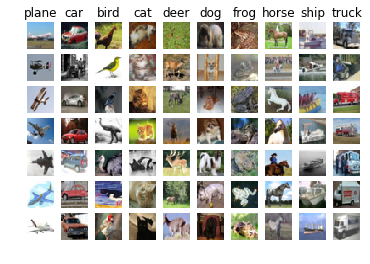

In [3]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [4]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [5]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[130.64189796 135.98173469 132.47391837 130.05569388 135.34804082
 131.75402041 130.96055102 136.14328571 132.47636735 131.48467347]


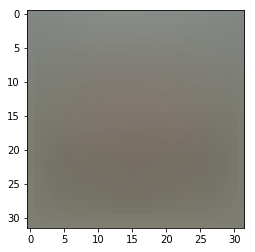

In [6]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

In [7]:
# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

In [8]:
# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


## SVM Classifier

Your code for this section will all be written inside **cs231n/classifiers/linear_svm.py**. 

As you can see, we have prefilled the function `compute_loss_naive` which uses for loops to evaluate the multiclass SVM loss function. 

In [9]:
# Evaluate the naive implementation of the loss we provided for you:
from cs231n.classifiers.linear_svm import svm_loss_naive
import time

# generate a random SVM weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001 

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.000005)
print('loss: %f' % (loss, ))

loss: 9.873826


The `grad` returned from the function above is right now all zero. Derive and implement the gradient for the SVM cost function and implement it inline inside the function `svm_loss_naive`. You will find it helpful to interleave your new code inside the existing function.

To check that you have correctly implemented the gradient correctly, you can numerically estimate the gradient of the loss function and compare the numeric estimate to the gradient that you computed. We have provided code that does this for you:

In [10]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at W.
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
loss, grad = svm_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: 12.171680 analytic: 12.171680, relative error: 9.971838e-12
numerical: -20.967057 analytic: -21.068005, relative error: 2.401514e-03
numerical: 13.872165 analytic: 13.872165, relative error: 2.086189e-11
numerical: 17.093341 analytic: 17.182226, relative error: 2.593252e-03
numerical: 4.352444 analytic: 4.352444, relative error: 1.235884e-10
numerical: -6.969179 analytic: -6.969179, relative error: 6.838989e-11
numerical: -28.141297 analytic: -28.141297, relative error: 1.584262e-11
numerical: 13.906415 analytic: 13.906415, relative error: 1.399302e-11
numerical: 16.811945 analytic: 16.811945, relative error: 1.176433e-11
numerical: -54.084641 analytic: -54.084641, relative error: 8.681330e-13
numerical: -3.065496 analytic: -3.065496, relative error: 4.472986e-12
numerical: -18.227513 analytic: -18.227513, relative error: 1.986088e-11
numerical: 13.395459 analytic: 13.395459, relative error: 2.321086e-11
numerical: 24.043921 analytic: 24.043921, relative error: 1.401298e-11


### Inline Question 1:
It is possible that once in a while a dimension in the gradcheck will not match exactly. What could such a discrepancy be caused by? Is it a reason for concern? What is a simple example in one dimension where a gradient check could fail? *Hint: the SVM loss function is not strictly speaking differentiable*

**Your Answer:** *In zero point, the Hinge Loss is not differentiable, so gradient check may fail*

In [11]:
# Next implement the function svm_loss_vectorized; for now only compute the loss;
# we will implement the gradient in a moment.
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.linear_svm import svm_loss_vectorized
tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference: %f' % (loss_naive - loss_vectorized))

Naive loss: 9.873826e+00 computed in 0.126535s
Vectorized loss: 9.873826e+00 computed in 0.006323s
difference: 0.000000


In [12]:
# Complete the implementation of svm_loss_vectorized, and compute the gradient
# of the loss function in a vectorized way.

# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

Naive loss and gradient: computed in 0.127330s
Vectorized loss and gradient: computed in 0.002981s
difference: 0.000000


### Stochastic Gradient Descent

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss.

In [ ]:
%pdb
import ipdb as pdb
pdb.set_trace()

Automatic pdb calling has been turned ON
--Call--
> /Users/liz/Desktop/code/DeepLearning/deeplearning-cs231n/assignment1/.env/lib/python3.6/site-packages/IPython/core/displayhook.py(247)__call__()
    246 
--> 247     def __call__(self, result=None):
    248         """Printing with history cache management.

ipdb> tbreak linear_classifier.py:62
*** 'linear_classifier.py' not found from sys.path
ipdb> tbreak cs231n/classifier/linear_classifier.py:62
*** 'cs231n/classifier/linear_classifier.py' not found from sys.path
ipdb> tbreak ./cs231n/classifier/linear_classifier.py:62
*** './cs231n/classifier/linear_classifier.py' not found from sys.path


In [15]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
from cs231n.classifiers import LinearSVM
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 778.227598
iteration 100 / 1500: loss 283.546934
iteration 200 / 1500: loss 106.934189
iteration 300 / 1500: loss 41.896195
iteration 400 / 1500: loss 18.612214
iteration 500 / 1500: loss 10.036994
iteration 600 / 1500: loss 6.979845
iteration 700 / 1500: loss 5.475618
iteration 800 / 1500: loss 5.482759
iteration 900 / 1500: loss 5.610847
iteration 1000 / 1500: loss 5.417842
iteration 1100 / 1500: loss 5.204109
iteration 1200 / 1500: loss 5.426375
iteration 1300 / 1500: loss 5.252791
iteration 1400 / 1500: loss 5.056730
That took 3.479491s


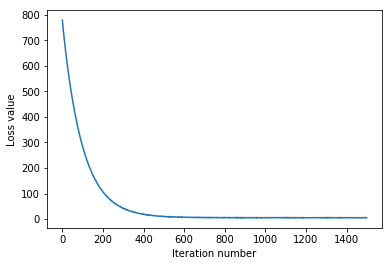

In [16]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [17]:
# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = svm.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.372490
validation accuracy: 0.380000


In [22]:
import ipdb as pdb
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.4 on the validation set.
learning_rates = [1e-7, 5e-5]
regularization_strengths = [2.5e4, 5e4]

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.

################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a linear SVM on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the LinearSVM object that achieves this  #
# accuracy in best_svm.                                                        #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the SVMs don't take much time to train; once you are #
# confident that your validation code works, you should rerun the validation   #
# code with a larger value for num_iters.                                      #
################################################################################
for lr in learning_rates:
    for rs in regularization_strengths:
        svm = LinearSVM()
        pdb.set_brack()
        loss_hist = svm.train(X_train, y_train, learning_rate=lr, reg=rs,
                              num_iters=1500,verbose=True)
        y_train_pred = svm.predict(X_train)
        train_acc = np.mean(y_train == y_train_pred)
        y_val_pred = svm.predict(X_val)
        val_acc = np.mean(y_val == y_val_pred)
        results[(lr,rs)] = (train_acc, val_acc)
        if val_acc > best_val:
            best_val = val_acc
            best_svm = svm
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

[[-72.90112562 -54.64559437  88.98086105 ...  15.14105785 -17.05412871
  -11.20707355]
 [ 43.95991617 -45.58368125   7.53254146 ...  -4.38782728  33.62466999
   10.84514685]
 [-26.19015211 -98.32579448   5.2033667  ... -39.67075871  10.74399524
    1.1099185 ]
 ...
 [ 82.65571897 -85.04453501 -24.56237317 ...  82.46041844  -7.12368324
   75.53694908]
 [  9.98232676 -26.95440482   9.42326009 ... 124.32177028 -63.03574552
   53.33462268]
 [ 38.65274374  57.88821824   8.94443382 ...   8.16776526  20.92431506
   79.14086695]]
iteration 0 / 1500: loss 778.538734
[[-97.6555054  -16.01148905  86.99224144 ...  10.34758174 -17.67706756
  -31.95424767]
 [ 25.53093853 -10.80265774   7.96213896 ...  -8.35924427  30.95663797
  -10.45898755]
 [-40.17052768 -66.83973163  15.22343762 ... -43.58505757  10.42790567
  -22.35800069]
 ...
 [ 73.43365221 -67.8508454  -30.40526742 ...  93.20554002 -14.80237462
   56.21495453]
 [  1.99443442  -3.81255994   8.05607951 ... 125.0792     -66.95756465
   32.060951

[[-61.2532722   -7.40460156  81.1806625  ...  12.82655072 -14.46655559
    6.78978826]
 [ 54.16140749  -3.14796808   8.04223357 ...  -5.20991691  31.22128172
   27.26063995]
 [ 11.99694816 -45.9640202   -2.84272092 ... -35.33328634  17.72153851
   21.94857187]
 ...
 [ 88.85762003 -55.09303947 -30.88550502 ...  72.00741909  -6.9942125
   68.57806669]
 [ 39.24888343  -0.68739003  -5.68462323 ... 104.90081832 -53.6150036
   46.6674715 ]
 [ 33.12199233  49.51098688   7.27173455 ...   6.89567866  17.85325401
   67.58101751]]
[[-58.53004523 -16.68413182  56.93533215 ...  12.24197929   5.25088015
    4.48455462]
 [ 46.10713004 -11.55460273  -9.48886791 ...  -3.33041987  49.345335
   21.79707655]
 [ -0.86799209 -56.50259071  -6.97513895 ... -27.78633685  28.27851919
   15.06274126]
 ...
 [ 96.11210418 -57.50051958 -36.58501831 ...  76.39564853  -6.17082226
   48.12088248]
 [ 42.89355758  -3.8320088   -2.15610369 ... 109.0102778  -56.03604216
   28.89919843]
 [ 32.76638237  49.13343194   7.4603

[[-48.7491804  -29.63159044  59.76471062 ...  18.4558126   -8.90932184
    8.36320823]
 [ 46.25862989 -19.39314976   3.03264216 ...   1.82728518  30.42864072
   23.50196   ]
 [  7.27310802 -64.48234342   3.06611327 ... -26.72766223  18.3734291
   13.22065397]
 ...
 [ 78.12664281 -70.74901959 -15.61076883 ...  74.06182436  -5.06135051
   69.73026564]
 [ 33.99169439 -30.69910139  15.09211681 ... 100.72671777 -47.16399619
   51.96129765]
 [ 29.74515021  44.3233845    6.87972913 ...   6.31363285  15.91498795
   60.89867774]]
[[-57.2362447   -7.2912033   55.95902942 ...  12.36018976  -3.38332492
   11.89396158]
 [ 43.91551021  -2.48454013  -9.53889095 ...   4.37568294  39.05871232
   23.76897061]
 [  8.02913432 -36.70258436 -12.64867342 ... -17.44004494  29.0643642
   13.58672621]
 ...
 [ 79.57720551 -45.96285082 -34.40306805 ...  53.10287973  -6.90151764
   61.59020207]
 [ 37.08169306   0.19343269 -12.72337592 ...  81.54702632 -41.52600692
   42.33136259]
 [ 29.49642446  44.19176758   6.77

[[-40.85016729 -29.27861019  60.35240847 ...  10.57433894   0.2044414
   -3.82434008]
 [ 42.88816878 -22.26037995   9.06904273 ...  -4.10786804  33.98247502
    6.57869346]
 [  8.18960358 -58.23314919   4.8970975  ... -22.87238641  27.24838132
   -4.98716384]
 ...
 [ 69.14580945 -37.60836349 -11.72542046 ...  39.3395677  -12.24310161
   43.97679813]
 [ 30.64117444   4.34746069   7.89396747 ...  62.40746041 -42.70949674
   30.70347372]
 [ 25.5169827   37.95683259   5.79571715 ...   5.28256623  13.95950903
   52.03001008]]
[[-45.66753686   5.54514633  42.83537785 ...  14.01524969   2.76024552
    1.6202203 ]
 [ 35.16007487  15.84012297  -6.27141677 ...  -3.38331034  39.5865351
   19.32735254]
 [  3.98843924 -13.06598467  -6.24469084 ... -23.41728651  28.63853248
   15.76748892]
 ...
 [ 69.71747224 -40.57857229 -25.61044479 ...  58.71323884 -13.29243957
   57.11864761]
 [ 36.79288285   7.62382195  -5.17362237 ...  89.42751739 -50.22409069
   43.02099278]
 [ 25.18939778  37.99704843   5.48

[[-30.35786653 -14.54777403  39.8816974  ...  12.80505988   2.62396877
    0.12018992]
 [ 45.85873679  -9.21536741  -9.06960796 ...   1.94673507  34.35289814
   10.91567347]
 [ 17.36746443 -38.32516377 -14.11621907 ... -16.52294474  28.60105002
    3.49077805]
 ...
 [ 73.54003593 -22.69991983 -29.14729741 ...  62.27273139  -6.67130398
   27.95646284]
 [ 37.63745703  16.52467349 -11.9314873  ...  86.1391975  -31.0298005
   14.45073855]
 [ 23.34551587  34.65049054   5.49546342 ...   4.8542124   12.79549158
   47.2056705 ]]
[[-45.03165016  16.14878311  28.5709729  ...  36.84880539 -10.86793352
  -16.3295695 ]
 [ 41.24033342  16.40860891 -16.99891757 ...  23.90535751  20.43211528
   -2.85968092]
 [ 13.41725874 -14.26403733 -21.6197888  ...  -0.19767736  12.24230681
   -2.14100461]
 ...
 [ 69.12127657 -28.08729493 -30.85676133 ...  66.03394406 -17.13831644
   28.33639114]
 [ 36.04417332  12.15800084 -16.49993915 ...  83.37946294 -47.78674578
   17.37670129]
 [ 23.00378829  34.36223809   5.2

[[-36.60066744 -10.60938345  37.08766981 ...  18.50864233  -6.87182071
   -0.48813604]
 [ 33.11190527  -9.02049803  -1.54550724 ...  13.02725447  21.29083665
    5.57823467]
 [  4.8274957  -36.4263061   -3.64318373 ...  -8.41651586  11.28699305
    2.90117745]
 ...
 [ 47.01418099 -40.65339136 -21.02944889 ...  56.2438372  -11.49811175
   35.91388367]
 [ 12.6530539   -5.82857278   1.49696672 ...  70.30669999 -38.42763588
   26.16875071]
 [ 20.04728026  29.70164374   4.50677889 ...   4.12897969  10.69853469
   40.89400967]]
[[-43.65391298  -7.87731684  24.82290738 ...  53.19305973 -12.80158426
    5.5508579 ]
 [ 27.56796666  -1.54866034 -18.55351031 ...  41.68864779  16.12248757
   15.55271798]
 [  1.57103312 -28.07919682 -21.10601108 ...  21.79561121  11.20499196
   10.28506218]
 ...
 [ 45.86857253 -29.45701053 -29.66982328 ...  50.48639026 -18.14215425
   47.85725955]
 [ 16.18370934   1.3976108  -15.19953526 ...  74.54108506 -44.75342484
   36.41096267]
 [ 19.76204386  29.64813553   4.

[[-36.58101269 -11.30207271  51.72601197 ...   9.62740972   0.91880953
    8.94983547]
 [ 23.14844529  -8.93724311  17.8184006  ...   2.4520662   26.45936329
   15.32358595]
 [  1.04996516 -24.58701712  19.29784772 ... -12.99116857  20.50128362
   11.86085168]
 ...
 [ 52.1774317  -38.18101783 -15.78949612 ...  38.41231109  -3.73989907
   42.29372415]
 [ 25.74351917  -6.16766887  -2.92800672 ...  53.87657486 -26.44590102
   37.01980034]
 [ 17.93723209  27.00143916   3.85582416 ...   3.80952193   9.73331388
   36.80143254]]
[[-31.31223028  -2.15049521  33.01994681 ...  -4.24241488  -9.0160889
   -6.76089402]
 [ 28.47580816   6.78372167  -6.86265466 ...  -8.83512576  13.87807107
    2.17370323]
 [  6.05914921 -13.68225632 -16.4571656  ... -23.80325477   7.90771169
   -1.65847482]
 ...
 [ 45.14501148 -19.83044988 -34.28981068 ...  32.76297851 -10.30860733
   35.25036941]
 [ 17.94187443  11.16519948 -24.84917811 ...  48.74007627 -33.20064794
   28.21674205]
 [ 18.01754593  26.93643197   4.2

[[-34.05168243  23.85509804  14.39007549 ...  19.87572147   2.17968448
  -11.5178122 ]
 [ 14.83018439  24.25751287 -16.58841598 ...   9.21371369  21.62978833
   -2.04793854]
 [-13.15294052   9.54531821 -16.17729397 ...  -2.39633634  14.13173601
   -4.8587436 ]
 ...
 [ 44.29301027 -31.76066776 -22.44963569 ...  41.65381069  -0.93356679
   33.98631356]
 [ 17.2474433   -6.36109945  -9.04254187 ...  59.13967916 -20.43315829
   24.46491054]
 [ 15.02352139  22.72143837   3.73935548 ...   3.34105637   8.23485002
   31.29165042]]
[[-23.10936494  -6.98633949  25.46515287 ...  14.57854072   1.14452912
  -14.50843263]
 [ 24.71623908  -2.44914    -10.85766573 ...  12.75689155  21.58718735
   -5.56760752]
 [  5.38275745 -20.47293001 -14.8745373  ...  -6.97007037  13.95685977
   -3.98681947]
 ...
 [ 45.95588685 -21.50962523 -13.94895241 ...  26.49205878 -13.99975773
   30.30707219]
 [ 29.24732823   1.35869747  -2.76938059 ...  33.57984576 -38.06297964
   23.82058813]
 [ 15.23340379  22.58783117   3.

[[-25.19313097 -19.57175104  38.34777823 ...   2.06722675  -8.28747088
   15.88054563]
 [ 20.69057567 -15.73414862   8.68693944 ...   2.10993126   9.56971732
   25.20798861]
 [ -2.01874134 -35.02145821   1.18465291 ...  -2.86003584   4.40654156
   24.9880208 ]
 ...
 [ 34.22940527 -29.44437728   5.08634614 ...  36.4296729  -15.84838137
   31.24166439]
 [  9.42907436  -3.63879974   9.02086751 ...  57.30820978 -35.35797177
   26.56750423]
 [ 13.94477523  21.06982397   3.22035967 ...   2.92145442   7.59496941
   28.40344316]]
[[-36.17618501  -9.14291198  25.46553352 ...  21.22915561   4.47957525
  -10.10439873]
 [ 10.95538759 -10.31221308   1.86567362 ...  14.9749066   23.60485955
   -1.89476358]
 [-10.24362539 -30.13632867   2.852187   ...   9.66037434  20.07663988
   -2.14222461]
 ...
 [ 38.38014436 -15.79526927 -28.55048192 ...  47.27370454  -0.94432396
   18.30530341]
 [ 19.99488827   4.97735355 -22.36730326 ...  55.89956373 -18.57222906
   16.70274385]
 [ 13.78005135  20.86947485   3.

[[-35.28938407  -5.30459848  31.52641493 ...  22.02988463   2.58827615
   -9.31500256]
 [  6.86562192  -0.99986378   8.70112361 ...  13.09235268  19.77181335
   -1.31539106]
 [ -8.62756253 -18.08745882   4.83488297 ...  -0.94188984  16.76898218
   -4.24098393]
 ...
 [ 30.31503952 -12.23410881 -23.22190433 ...  33.98387741   4.65159517
   19.00710335]
 [ 11.57073908   9.84323218 -21.4274306  ...  49.5805866   -6.52290141
   10.52330829]
 [ 12.08078169  18.31194466   2.8109233  ...   2.2898751    6.64330834
   24.92005417]]
[[-35.79891746   7.60148584  17.88266827 ...  -4.55506336   4.85459171
   -1.69707571]
 [  3.79302901   9.47858299  -6.87320395 ...  -9.22927337  21.27240633
    6.61472467]
 [ -9.90444696  -2.62673847 -13.48796512 ... -16.16670325  16.61435482
    8.47813446]
 ...
 [ 39.5815782   -7.78967174 -15.47200665 ...  21.30794659  -0.53080403
   16.67102457]
 [ 24.19492609  14.70297959  -5.35231273 ...  33.30377367 -13.89829976
    7.79265746]
 [ 12.11537778  18.13538493   2.

[[-29.1341125   -3.62247857  26.850076   ...  27.13802431  10.13795095
  -15.43205886]
 [  7.73798811   4.461466     4.90691617 ...  20.61089547  27.15623881
   -9.85225252]
 [ -8.08516645  -8.09201454   0.04861642 ...  14.06198672  23.84329216
  -15.13066923]
 ...
 [ 11.76549323 -13.66747702  -6.93678253 ...   3.9658991    1.91815941
   24.96948592]
 [ -5.63774821  10.67287647   5.08669193 ...  11.55626854 -10.97099333
   17.68845332]
 [ 11.13371074  16.8622531    2.54571821 ...   2.09847472   5.99045991
   22.90927788]]
[[-34.74202296   7.62438494  25.60778624 ...  -1.16165418   4.88905171
   -1.77236499]
 [  2.84411551   9.38077959   2.55891118 ...  -6.84149676  18.40554894
    3.19764803]
 [ -6.15500144  -3.33887957   0.76841783 ... -15.33523791  14.9317061
   -2.66160302]
 ...
 [ 29.44528535 -27.09967719  -9.52832637 ...  13.20386226   6.25925882
   32.14946992]
 [ 16.47443624  -5.4765672   -2.61782296 ...  21.64462006  -8.50813622
   23.32602605]
 [ 11.06804218  16.59294183   2.3

[[-12.08203613  11.17171266  20.22686558 ...   8.61688385  -5.79309826
  -10.16904601]
 [ 18.49594299  15.3778261   -0.28409433 ...   4.89069448   6.66564578
   -4.75885585]
 [  4.79874342   7.80888672  -5.94154958 ...   1.63909809   4.33859724
   -6.45615924]
 ...
 [ 28.19010749 -11.59355765 -11.70596944 ...  21.59730359   2.32757342
   23.86454153]
 [ 10.35314382   6.24984875   0.21797454 ...  31.51278518 -13.67889032
   18.10387141]
 [  9.64055479  14.40087623   2.35627348 ...   2.01252087   4.98504621
   19.42967355]]
[[-25.11280768   8.14338767   3.79569992 ...  18.29457831  -0.22690358
   -8.54269496]
 [ 15.80636277  10.53657625 -18.14507131 ...  13.68567009  13.60396143
   -4.96723044]
 [  6.21925031   1.02825514 -14.2849049  ...  -0.2595523   12.11425161
   -9.32233579]
 ...
 [ 41.25328226 -15.15575843 -15.43834612 ...   5.70221463 -13.03164078
   21.16161515]
 [ 26.10732881   0.37461451  -4.14628891 ...   7.03209054 -25.19645729
   18.14141848]
 [  9.47735202  14.36387185   1.

[[-18.86558658  16.3672764   30.70766637 ...   6.80442258   9.57312973
   -7.44551258]
 [ 11.95048463  20.06774066  12.33124057 ...  -2.57607319  19.78219716
   -3.10780087]
 [  2.12848383  11.27220599  12.62327104 ... -10.81524092  11.07798455
    1.36427626]
 ...
 [ 22.67202427 -14.46331015 -11.32745057 ...  15.60695501   3.71629689
   25.59106315]
 [  8.10637683   7.36077474  -2.85416376 ...  16.82870092  -8.61749945
   21.62695562]
 [  8.61210094  13.54679026   1.85057592 ...   2.20084603   4.63998688
   18.11213815]]
[[-16.75977252   1.35949553  23.09554702 ...   1.04236108 -15.66983888
   12.90083764]
 [  8.71182813  -0.64698172   4.09440172 ...   2.95833677   1.66312648
    7.42463303]
 [ -5.35059369 -10.25041463   6.32489386 ...   0.75387978   3.44200626
   -2.951979  ]
 ...
 [ 28.6769466  -10.36912339 -16.08219373 ...  21.11769248 -14.25570378
   15.95964089]
 [ 13.92687066   6.64486801  -8.74589722 ...  25.37047599 -25.79029838
   19.00674798]
 [  8.62904043  13.23905631   1.

[[-14.19735756  15.01262297  25.34926812 ...  -1.46388904  -7.39481654
  -12.34002439]
 [  8.76942143  24.40624672   1.81812334 ...  -6.63935598   2.63593492
   -9.46106927]
 [  1.90258023  20.60434261   8.28134087 ... -17.1785365   -2.66656434
  -11.4637232 ]
 ...
 [ 13.36534259   2.73997961  -4.26246042 ...  15.84904153  -5.56070879
   17.55208385]
 [  9.04341786  19.36491121   5.18096707 ...  19.72205067 -15.86432754
   11.34030974]
 [  7.86444158  11.15000204   1.74475609 ...   1.8065882    4.19254766
   15.16182111]]
[[-19.94410577 -22.49321902  16.66461668 ...  -0.66943888   2.77820499
   -8.00501631]
 [  5.61109932 -18.5852136    0.39311946 ...  -2.55819135  12.89729862
   -4.29017923]
 [ -4.51582267 -29.4482242   -2.85636992 ... -12.42018525   9.85861644
   -7.94414621]
 ...
 [ 16.61969587 -27.73661784  -8.47805016 ...   8.14665061   0.93864374
   12.62420261]
 [  4.68609577 -15.44378263  -7.9349592  ...  16.51227542  -4.69001662
   10.97580962]
 [  7.58011938  11.39925203   1.

[[-14.61159384 -13.44857714  19.48854011 ...   3.72885018  -6.869886
    4.61308873]
 [  7.1131895   -9.63810536  16.91123297 ...   0.07912436   0.30651142
    4.96749028]
 [ -3.09894716 -15.96049026  26.48041554 ...  -7.14832461  -4.31234223
    2.97138518]
 ...
 [ 17.0498824  -11.11282983  17.72944007 ...  17.90244949  -7.08741298
   10.03943614]
 [  3.94377991   5.69281719  26.39375814 ...  22.73786254 -18.99862926
    4.61141632]
 [  6.96655336  10.14301528   1.50248358 ...   1.48723515   3.60162928
   13.99683636]]
[[-11.76350005   3.68362993  -9.97616759 ... -10.43671887  -0.14354463
   16.26786125]
 [  2.23650467   5.77120405 -20.0888482  ... -17.29391973  13.37390591
   18.66728752]
 [-14.82968977  -3.03945046 -21.26309653 ... -23.23886483  10.79232703
   15.76100662]
 ...
 [ 17.76338931   0.83397799  -8.09538713 ...  11.40292132   2.79770286
   17.34647814]
 [  7.20791744  14.73549667  -5.67110565 ...  13.07211109  -6.04954397
   14.73635067]
 [  6.59672059  10.4273002    1.73

[[ -6.55302998   6.51295051  17.3656123  ...  -7.9790504   -6.89309823
    5.84667835]
 [ 13.95666365  11.00007397   2.88541561 ...  -6.19360039   2.64238565
    8.28890804]
 [  3.12590535   2.12428727   5.53965786 ...  -6.61706485   1.09266401
   11.44607142]
 ...
 [ 13.88516326 -13.74684222  -2.2325917  ...   3.75926153  -8.03298189
   26.64087214]
 [  5.61481672  -5.25866072   5.47951275 ...  11.28049578 -17.00550294
   22.73199898]
 [  5.67658876   8.65587544   1.07848105 ...   1.01911711   3.22353692
   11.59625794]]
[[ -3.49063636 -21.10633761  11.61898567 ...  18.08912149   3.95704318
    4.48578873]
 [ 14.54160635 -22.51873916   3.68982424 ...  15.81355486  10.27844311
    5.44492932]
 [  6.7073846  -30.83713886   3.18743672 ...  13.84521578   6.32615742
    9.89986209]
 ...
 [ 16.26866683 -13.95913535   0.69755983 ...  -2.56056212  -0.54333862
    1.85130329]
 [  2.9427362   -3.17333956   6.45820519 ...   1.45812116  -5.10449256
    1.98439684]
 [  5.63320582   8.67759606   1.

[[ -5.5269992   11.21923535   2.42281083 ...   8.0393465    0.69656798
    1.25075413]
 [ 10.58551029  12.4070286  -11.78968682 ...   9.89706649   5.50242325
    6.39688268]
 [  0.7831647    7.76048824 -23.40203053 ...   5.40733256   2.79666121
    6.35900335]
 ...
 [  6.53545692 -16.95902283 -12.59195923 ...  14.99250267   4.0395857
   22.1127179 ]
 [ -0.30548433  -3.51398164 -16.84350014 ...  23.70368667  -1.5647401
   18.62675969]
 [  5.27940485   7.87846042   1.0728484  ...   1.00420675   2.9065787
   10.82114895]]
[[-15.46980287   6.77597714   8.84921065 ...  28.67563589   0.15778075
  -15.14293025]
 [ -4.39396981  13.38962815   2.04316569 ...  25.60867707   6.80091572
  -17.13058133]
 [-10.15046806   7.44116417  -7.51158528 ...  24.4018608    4.04661239
  -19.67561616]
 ...
 [ 14.66104617  -1.61198854   8.64771811 ...  13.70082261  -3.00301999
  -12.59425794]
 [  9.21500666   7.3765797    5.32469165 ...  20.44619395  -9.25389283
  -16.19650268]
 [  5.16800783   7.81906812   1.007

[[ -2.35933562  -5.52558273  -1.09135909 ...  -4.19160217  10.18378689
   23.95158225]
 [ 10.35109349  -2.40359099  -7.99350931 ...  -3.03211209  15.29506435
   25.47843501]
 [  1.1374882   -4.78211446  -9.56941397 ... -10.00292871  12.16943218
   20.61408567]
 ...
 [  7.00473238  -7.72903855   3.65142925 ...   5.92787123   4.10278873
   31.89369835]
 [ -0.8253801    2.64864226   4.93417769 ...   6.77580747  -0.7714119
   27.68398778]
 [  4.44381122   6.40981766   1.0641978  ...   0.95335656   2.30755543
    8.82430162]]
[[ 12.31006177  -4.34221175   2.64822036 ...   5.18584196  11.63516428
  -10.01932607]
 [ 25.54125588  -4.55102507 -11.79664686 ...   0.85914439  16.67151148
   -7.23366023]
 [ 22.60203933 -12.32242144 -10.00600078 ...  -2.50134917  14.35275808
   -7.08142109]
 ...
 [ 13.954203     2.62374787 -22.71029484 ...  27.51651432   8.60436132
    3.2892617 ]
 [ 13.2217918    8.5084119  -10.44756605 ...  28.26795414   3.74351373
    0.91469213]
 [  4.52659216   6.40776857   0.8

[[-8.58788684 -3.08139007 26.89010004 ...  1.93204553  3.15516456
   0.15494595]
 [ 4.18955646 -4.19368933 20.95291116 ...  6.9524892  10.0201291
   2.3886812 ]
 [ 0.14396195 -5.97492535 16.78056349 ...  6.55037476  8.18124051
  -0.03121673]
 ...
 [12.43705777 -6.89724014 19.74014468 ... 11.29273685 -3.05482796
  13.57229767]
 [ 9.50981079  3.90117387 13.12818042 ... 16.81351055 -8.47399763
  10.86604816]
 [ 4.36954008  6.00154679  0.79386412 ...  0.60969357  2.08075809
   8.00265737]]
[[-16.91139771  -4.16824812  -8.31303444 ...   6.19856704  -7.76584851
   25.78744785]
 [ -0.36860612  -2.14324589 -14.52719574 ...   5.55482727  -3.49768839
   20.04292504]
 [ -2.3245601   -8.04616072 -16.39918851 ...   4.85312228  -6.34890549
   14.29813466]
 ...
 [ 16.03534636   3.02606606  -2.31335563 ...   8.83714786  -3.31229872
    5.86340883]
 [ 10.18509245   7.913773    -4.85935119 ...   7.38849228  -9.14657407
    6.07574578]
 [  3.95269238   6.21653906   1.0448948  ...   0.7216451    2.1953543

[[ 1.28430997e+01 -8.38189663e+00  3.08212816e+00 ...  2.92027088e+00
  -4.67606474e+00 -1.99267511e+00]
 [ 2.29799469e+01 -5.70375874e+00 -1.74205437e+00 ...  1.19164370e+00
   7.95152448e-01 -7.57383222e-01]
 [ 1.72442422e+01 -1.34998018e+01 -5.55963387e+00 ... -1.94868089e+00
  -1.36875543e+00  4.44961966e+00]
 ...
 [ 2.45756443e+01 -1.29710133e+01 -1.43992657e+01 ...  1.09824721e+01
   4.31837174e+00  9.84012436e+00]
 [ 1.66516086e+01 -3.44488534e+00 -1.33440886e+01 ...  1.25693128e+01
   1.09807022e-02  1.10469120e+01]
 [ 3.33310190e+00  4.99276957e+00  9.40331528e-01 ...  8.60845055e-01
   1.86949083e+00  7.32558840e+00]]
[[ -9.09895378  -1.29421276   6.66570589 ...   3.57127831  -2.43298881
    6.39424888]
 [  0.69041242   0.41270546  -3.82400634 ...   0.7836763    2.36718128
    9.81293329]
 [ -8.63145741  -4.87845725   6.75007899 ...  -2.45180647   6.93202284
   11.04741605]
 ...
 [  0.17052686  -1.66611052  -6.37006205 ...   8.25737526   6.61937213
   11.24469598]
 [-11.52964

[[-19.92185361   6.50835021  19.02673777 ...   7.9929296    5.49819582
  -13.53613898]
 [ -3.53055325   7.91706771   5.32839473 ...   6.39338422   9.91270645
  -18.96472587]
 [ -0.44155535   5.74884225  -9.33015655 ...   1.91971141   8.28682948
  -23.82510135]
 ...
 [ 10.05852954  -5.49280039   3.64179609 ...  -7.01088042   8.46826891
    0.90778451]
 [  7.30393967   3.94924114  -1.50965099 ...  -4.92099987   6.35898197
   -0.45041726]
 [  3.31043472   5.08029654   0.77450122 ...   0.43738659   1.83701197
    6.48378739]]
[[-1.98980546e+01 -6.35452726e+00  2.40175172e+01 ... -2.16811831e+00
  -4.16257179e+00  4.82846652e+00]
 [-6.73972702e+00 -6.42891049e+00  1.77137390e+01 ... -2.22700719e+00
   4.58195567e+00 -2.72725377e+00]
 [-1.03919557e+01 -1.47440305e+01  2.46646908e+01 ... -5.68549776e+00
   5.70620003e+00 -5.72969401e+00]
 ...
 [-6.79056719e+00 -1.03036507e+01  2.48408104e+01 ...  7.15386868e+00
  -9.16804508e+00  1.83632615e+01]
 [-9.10262288e+00 -2.06550614e-02  2.59438265e+

[[-1.97493976e+01  2.39120852e-01  1.47742702e+01 ...  7.93934572e+00
  -3.52907793e+00  6.46432996e+00]
 [-1.08539875e+01  2.39191938e+00  1.13139666e+01 ...  6.60195630e+00
   1.19357718e-02  8.72925652e+00]
 [-1.54893218e+01  2.27984958e-02  6.93846796e+00 ...  7.99721737e+00
  -3.25219221e+00  1.12026165e+01]
 ...
 [ 9.98065529e+00 -9.26170989e+00  3.66250416e+00 ...  1.63102317e+01
  -1.92183088e+01 -1.99268489e+00]
 [ 3.03756098e+00  3.50911641e+00 -3.64073054e+00 ...  1.82690207e+01
  -2.37828352e+01 -1.60191557e-01]
 [ 2.70553115e+00  4.49057683e+00  4.70575095e-01 ...  5.76823889e-01
   1.25093889e+00  5.52246008e+00]]
[[ -6.73027912   4.70053045   8.79985726 ...  13.94150665   7.86197838
   -8.3360669 ]
 [  3.55055637   5.90336132   3.46068454 ...  18.41531641   7.93062048
   -4.8617413 ]
 [  2.68601605   2.43862267  -1.86152969 ...  17.37668741  10.07691548
   -0.82211478]
 ...
 [  3.68782263   2.00694274   9.46903898 ...   4.18403359 -11.29891893
   -1.28770554]
 [  0.69637

[[  6.4479989  -17.50249642  -5.3414277  ...   8.60224466  -8.26830795
    4.33175904]
 [ 11.98893043 -16.4626092  -10.65727216 ...  12.86639079  -4.62758796
    7.40964264]
 [  9.23777862 -19.93665713  -3.48049727 ...  10.04464389  -7.67749245
    6.59463119]
 ...
 [ 13.2226688  -25.42519774   8.61455877 ...   1.8702607   -5.57429284
   15.45620188]
 [ 13.32631226 -22.00802647  12.01664422 ...  -0.56769702  -9.60531507
   12.10709904]
 [  2.58547505   3.67289152   0.38026132 ...   0.71415221   1.20309093
    4.82509705]]
[[ -8.33988119  19.45748249  16.02054801 ... -12.44096799  -4.81146059
  -13.08074578]
 [  1.45859751  23.26906456   9.07112848 ... -13.28177688  -2.5466189
  -11.13811323]
 [ -4.60860435  23.5346133   10.33420807 ... -16.40605648  -3.85256234
   -9.88971278]
 ...
 [ 19.66083341  11.73709682  -8.9148626  ...   4.10192083 -11.82502505
   -0.60863954]
 [ 11.93755427  12.37599866  -0.525319   ...   8.58905147 -14.20422206
   -0.46233574]
 [  2.27754768   3.61952706   0.6

[[ -3.60313305  26.79058836  -2.41764245 ...  -3.90970225  -2.82137644
  -13.17974268]
 [  3.50710903  26.71269946  -7.13106309 ...  -3.7940647   -1.22686741
  -20.10025214]
 [ -4.04371222  35.86856846 -11.2892929  ...  -0.57822495   0.61680104
  -26.52570426]
 ...
 [  1.18437418   1.46747206  -5.0071532  ...   4.18109053  -6.55177225
   10.59645327]
 [ -2.00467799  13.94540284  -0.12177766 ...  12.72403376 -11.27139394
    5.65383999]
 [  1.99885969   3.00506451   0.5696964  ...   0.56786811   1.19494623
    4.04963128]]
[[  5.43413955   6.25004634   8.63542607 ...  -4.33326027   3.44462391
    3.21987134]
 [ 11.27902553   3.28288035   0.58785702 ...   2.28015665   7.67451795
    3.45298891]
 [  9.90572389  -2.47792764  -5.63782419 ...   5.85788495   8.83693581
    4.51583651]
 ...
 [ 17.90431108 -10.41656693   7.47976869 ...  12.74929447  -8.889904
    9.96917713]
 [ 15.34233254  -7.21623632  -2.50320949 ...  17.19430216 -16.3161484
   14.93563507]
 [  1.95886539   3.19503919   0.471

[[ -2.57973736  -0.28260601  -1.9401044  ...  17.79976883   1.80537006
    5.12899897]
 [ -2.45831464   2.4259244   -1.30570894 ...  20.5300569    3.91233366
    5.60191812]
 [ -9.67929973   1.73431328   6.616112   ...  22.84060705  -2.7226994
    9.25553326]
 ...
 [ -4.36389804  -8.07343107  18.02847553 ...   7.37522938  -3.76211656
   11.56916556]
 [ -4.04460797   6.30730907  18.04484507 ...   9.18962996 -10.45992261
    8.39961515]
 [  1.86431971   2.73717427   0.21361502 ...   0.33229667   1.04624518
    3.73727717]]
[[  7.13458031  -2.43889665   6.13452898 ... -21.79139205   8.72911403
   15.92189918]
 [ 13.49879428  -1.72828277   2.65454103 ... -24.98795869  12.01612812
   17.06021006]
 [ 12.37883595  -8.85018522  10.58620572 ... -26.76911762   7.61356675
   15.92075375]
 ...
 [  5.35154104   4.51402261   9.7286703  ...   5.11059242  15.85427035
   20.29894381]
 [  4.99961078   1.3318411    7.35259084 ...   6.68667324  13.71833843
   21.40976494]
 [  1.84499811   2.88348839   0.1

[[  5.33462847   1.35026568  -5.21925468 ...  -4.20920969   0.88379268
   10.10985909]
 [  9.67961591   5.82171327 -10.17379876 ...  -7.75283046   5.66693993
   10.81792353]
 [  3.99035722   6.49258772  -6.14355083 ... -13.17264015   2.96057526
    9.15821229]
 ...
 [ 10.11025238 -26.14334408  -2.1526073  ...  10.92533924   2.34264934
   12.68639035]
 [  7.62173267 -24.10976318   3.14983167 ...  14.29324876  -1.0558957
   10.58133776]
 [  1.51478864   2.29182942   0.40308963 ...  -0.14360381   0.92194113
    3.30603619]]
[[-2.03390233e+00  9.26011885e-02  3.06439365e+01 ... -1.26959031e+01
  -1.46332996e+00 -1.47736625e+01]
 [-3.01520641e-02  5.65618481e-01  3.13161570e+01 ... -1.43450250e+01
   2.76152768e+00 -1.36483579e+01]
 [-1.46405069e+00 -1.44807175e+00  3.35458628e+01 ... -1.65163665e+01
   3.40994545e+00 -1.68957086e+01]
 ...
 [-1.80606519e+01 -3.86485062e+00  1.55562537e+01 ... -2.80095725e+00
  -5.08697738e+00  1.76563935e+01]
 [-2.13464081e+01 -1.02514365e+00  1.56690611e+0

[[  0.26311946   0.90306166  -0.25075486 ...  -5.2027313   -4.88196921
  -14.5128418 ]
 [  1.61692402  -0.64618838  -8.71496307 ...  -5.75016764  -0.86180355
  -12.3580673 ]
 [ -0.90866374  -6.63937354  -7.9131611  ...  -4.40524243  -1.74613318
   -7.16952588]
 ...
 [ 10.70188603   5.12177135   6.29146222 ... -11.12454706  -2.2020519
  -12.93748586]
 [ 15.43385244   8.87203068  10.6246251  ...   1.10287993  -4.51690592
  -16.92068556]
 [  1.51098755   2.18843887   0.46739536 ...   0.12313963   0.78199283
    3.0042525 ]]
[[ -0.61772165  12.24162156   9.07975586 ... -23.81783224   4.7870691
    6.87576986]
 [  0.30427307  13.40439409   9.74306379 ... -21.79723874   2.67223149
    9.8182664 ]
 [ -3.95564083  17.06254149   4.57062226 ... -23.24188989   4.09970626
   12.56816971]
 ...
 [ -2.47113361   0.76614658  13.51086368 ... -11.55513616   1.08688775
   11.98875055]
 [ -7.13842396   3.94060838   9.08348912 ...  -6.85465375  -2.13832782
   13.07890715]
 [  1.25343261   2.03249667   0.43

[[-10.37561731   8.35172239   0.83128499 ... -19.67576062  -7.84048928
    1.381406  ]
 [ -1.22234983   5.38191217  -2.69030139 ... -23.94010139  -1.61219653
    1.91927062]
 [  1.60369149   2.43186969  -7.38098406 ... -30.26271735   0.88444105
    5.90150653]
 ...
 [ -1.78764717 -19.14062243 -12.57675624 ...   4.61560413  -3.50676562
   -2.42312461]
 [ -5.72450632 -12.1062603  -12.77609493 ...   5.5721201   -5.73105518
    0.22868866]
 [  1.20738717   1.67697788   0.45307281 ...   0.41092765   0.74069914
    2.58814911]]
[[ -4.56275892  -5.96175959   0.11581255 ...   6.7905591   -1.1518956
   -2.2911098 ]
 [ -6.83297328  -3.95381015   4.06849246 ...  -2.22060649   0.51287363
    0.33668345]
 [-15.19930472  -6.60109435   5.61677004 ...  -8.44633703  -0.83711217
    4.24486797]
 ...
 [  0.97317719   7.75405333   5.44092714 ...   1.60318448  -5.5040473
   -4.2408245 ]
 [ -3.4379245    3.17829886  -0.14532374 ...   7.63313735  -7.65635276
   -4.89640764]
 [  1.10635024   1.73359299   0.19

[[ -6.24397561   3.45667802 -13.85280675 ...   5.05103161   5.64219548
  -12.76460779]
 [ -4.32583659   4.1280592  -16.03350412 ...  11.08632872   6.49549361
  -16.47466503]
 [ -1.04476477   2.24832931 -21.18253944 ...  11.26411943   6.55666316
  -14.26815955]
 ...
 [ -4.2700641    3.03189826  -5.97772221 ...  15.3594326   -0.99094645
   -5.09231285]
 [ -6.69976922  19.31384241 -10.51714096 ...  12.98244178  -2.9911804
   -1.63279862]
 [  1.10192044   1.65638593   0.38014141 ...   0.21941873   0.74686898
    2.1926112 ]]
[[ -1.65917472  -5.23442363  27.88693178 ...  -5.26378488 -11.9816556
   -5.05429863]
 [  1.94597525  -4.74548058  29.28709707 ...  -5.71255037 -12.01237212
   -2.44119579]
 [ -1.91928013  -7.92741295  38.64685285 ...  -7.59748423 -13.12631424
   -0.04525385]
 ...
 [  6.61766662  -6.85238654  20.0776562  ...  -4.05563109 -12.57171376
   -0.96856883]
 [  3.61973391  -6.23867752  26.1503376  ...  -1.991434   -13.06835093
    3.59139109]
 [  1.10641084   1.763104     0.12

[[ -1.22043856   6.20606461  -8.08754611 ...   2.80098501  -3.82757851
    1.50988752]
 [  0.27312259   6.4468026   -6.12647715 ...   3.58083216  -3.81045024
    3.44628103]
 [ -7.40432052   2.96827078   1.18380164 ...   4.17026596 -10.09099482
    1.2520579 ]
 ...
 [  1.67724537  -2.46002417  -1.43650853 ...   4.25236849 -15.95473281
    2.17475125]
 [ -4.38002052  -2.92329303  -1.97903402 ...   6.99692933 -15.79341039
    0.64877044]
 [  1.04182168   1.39438193   0.10001561 ...   0.0727594    0.46991007
    2.15285134]]
[[ -9.78112688  10.88040582  -1.86747991 ... -17.64214257   9.21199806
   -3.10391079]
 [ -6.58333435   3.68984256   1.00888126 ... -22.17396689   7.80015456
   -0.88432946]
 [ -5.32492932  -9.16367935   2.70999141 ... -23.07615149  10.65417709
    3.49347251]
 ...
 [  6.41816894  13.04434657 -22.8913966  ...  -3.80042641  -6.77822568
   14.07833994]
 [  8.28387744   7.63532986 -12.63814528 ...  -8.25598246  -6.78840691
   14.1394473 ]
 [  1.03161257   1.40241002   0.

[[ -3.23666563 -13.57395308  -5.48992252 ...  -2.01334245   4.64742868
   -3.30224861]
 [ -1.82917884 -10.12981943  -9.70158285 ...  -0.16368927   8.49273015
   -7.00696595]
 [ -3.13564465 -10.09286926 -10.46085389 ...   5.59355223  10.07730136
  -13.0701566 ]
 ...
 [ 17.83339408  -6.42445899   6.48092852 ...   1.08272446  -8.75963636
  -14.06682647]
 [ 13.25019146  -5.29327443   6.18988749 ...   8.97499936  -5.02974136
  -12.17885266]
 [  0.93758072   1.28755285  -0.02126327 ...   0.28052356   0.75826379
    1.74064683]]
[[-13.41987353   2.2623276   15.94353872 ...  -8.96148523  -9.71131428
   23.7730809 ]
 [ -9.94204213   1.34957406   9.18258731 ...  -2.9927795   -7.01756462
   28.57596837]
 [ -9.38783541  -0.48455818  -2.07046432 ...  -1.05178512  -4.7446278
   31.99969479]
 ...
 [ -0.30095738  -4.75403833   8.57131653 ...  11.20800104  -0.3822345
    4.12763297]
 [ -1.87210664  -1.5837202    4.05007091 ...  10.6731265   -1.39765908
    4.26299232]
 [  0.82289282   1.48611508   0.28

[[  2.88499981  -9.33041721  -9.08618984 ...  -1.10771643   4.997944
   17.71083044]
 [  3.3286665  -10.47902791  -8.25928808 ...   2.87817611   8.75599505
   14.63785139]
 [  5.47767995 -12.3440752    3.17689593 ...  -4.12137942  11.7911466
   14.52598773]
 ...
 [-11.25918658 -12.36006498  18.02354166 ...   8.7002086   -0.23686459
  -14.72957651]
 [ -9.69186755  -8.96870196  22.61598447 ...   3.93616186  -2.37109665
  -18.76957092]
 [  0.87027003   1.21511044  -0.04205959 ...   0.14072177   0.51008925
    1.40363464]]
[[ -1.07108141  -0.23433809  -5.05035603 ...  17.76690899  -4.13576102
    6.05741057]
 [  4.37448899  -1.27074247  -6.99532021 ...  15.28679901  -0.97052472
    6.67221928]
 [  2.54131257   3.15427681  -7.39803426 ...  11.31603094  -3.82172138
    6.08700922]
 ...
 [  4.06574487   7.73567617 -10.92359891 ...   7.75448429  -0.21638639
    3.03339709]
 [  1.24764964  14.33104512 -10.28991546 ...  10.57555177  -3.26430545
   -0.54666307]
 [  1.00091868   0.98403489   0.378

[[ -5.15414596  -3.47613063  -5.48337    ...  -0.60149231  -2.55723541
   -5.20822393]
 [ -0.25528076  -4.89173279  -9.28022353 ...   1.38497728   0.58183888
    2.13591209]
 [ -5.72623534  -4.05164651 -11.6098093  ...   3.51421242  -0.14604482
    1.87513974]
 ...
 [  0.97361414   2.70614355  -6.99102444 ...  -2.18528966   4.90835317
    2.8519778 ]
 [ -5.77661304   5.35707124  -7.36872822 ...  -2.26510754   4.17550404
    5.30344598]
 [  0.69630926   0.906411     0.15147222 ...   0.15451323   0.30880474
    1.64945992]]
[[ -4.18759636 -14.2384814    8.96620889 ...   3.07823852   4.6017325
   20.37258444]
 [ -3.14957528 -14.40215984  12.0615429  ...   3.36186515   5.82103019
   23.07899936]
 [ -4.93305906 -17.08908542  25.47876138 ...   6.63244605   2.52518479
   15.82222384]
 ...
 [-19.56835638  -0.69373574   0.2766915  ...  -0.14333587  -6.6803139
   17.06782281]
 [-17.03086069  -0.15659412   7.850124   ...  -0.69780986  -8.2963242
    9.78766518]
 [  0.38782771   1.18187894   0.170

[[ 1.13486059 18.31707162 -1.78463951 ...  7.35118577 -5.06355032
   4.82193865]
 [ 1.82435856 16.14016479  1.7641107  ...  1.30171271 -1.41103209
   7.33250771]
 [ 8.26837245  7.08923823  8.04943011 ... -1.24322787 -0.83044758
   8.23364264]
 ...
 [ 9.39813463 10.43397604  0.07616527 ... -5.58838111 -2.3935926
   3.45504522]
 [10.9353325   5.61370981  5.42993596 ... -7.06666151 -1.23798376
   1.35538138]
 [ 0.76697144  0.79170545  0.14095228 ...  0.07952931  0.445105
   1.35349338]]
[[ -2.44655678 -12.41377067  15.51435083 ...  20.58746923  -4.90640624
    0.34076988]
 [ -0.63531119  -7.53998808  11.57156872 ...  24.77367455  -1.58500448
   -6.32936044]
 [ -0.73375186  -7.44042551   9.95100867 ...  32.21294378  -0.78990228
   -7.40745884]
 ...
 [ -0.21799727   6.96594738 -16.1895527  ...  20.58578855  -1.8121781
   -0.82157164]
 [  0.62764298   1.52365411 -10.00018372 ...  25.16775322  -5.14493527
   -1.08251766]
 [  0.73313658   0.81774692   0.21024752 ...   0.26913166   0.11287948
 

[[  4.58359307   8.62586363  -4.74248024 ...  -7.75337368  -3.01581965
   13.40106804]
 [  4.47596293   4.56379066 -12.79993552 ...  -3.47163361   1.790372
   13.17910578]
 [  2.42361389  13.14164197 -19.62693657 ...   0.52957902   4.03397053
   15.54101336]
 ...
 [  5.71500885  -4.82935081   6.21044965 ...  -6.78065703  -4.23599201
    9.09775879]
 [  3.0228548    2.97924457   6.57776105 ...  -0.95391963  -5.23827579
   10.41002744]
 [  0.49680214   1.09241285   0.0420092  ...  -0.06853673   0.30103711
    1.09815995]]
[[-14.94648694   7.57976206  15.24325992 ...  17.90755523  -4.58560627
   -8.0838424 ]
 [-15.67678219   6.60377987  11.54687232 ...  21.34608986   0.39897728
  -13.79270302]
 [-12.82902581   8.57280396   4.27306831 ...  25.08245276   1.12745211
  -13.22799579]
 ...
 [ 12.80867299   7.75823104  16.1828325  ... -13.71899293  -5.15548634
  -11.05463205]
 [  9.92073196  11.49229692  13.40282082 ... -14.79714146  -4.75802441
  -10.38704413]
 [  0.47431813   0.96695078  -0.07

[[  9.99120579   8.90552055   2.20640121 ...  20.04487773   3.68681375
  -13.84185994]
 [  9.87558226   3.38210811  -0.12777218 ...  21.53558302   3.29632782
  -14.56238285]
 [  5.64052269   0.87196811   6.90250972 ...  25.21284715   2.60562377
  -10.04623455]
 ...
 [  7.25396854   0.30518324  -4.49373625 ...  11.78512538  -4.59666381
    8.58933035]
 [  8.52635148   0.26078919   3.27518425 ...   9.3057908   -6.23659175
   14.83084651]
 [  0.467272     0.7614259   -0.1071509  ...   0.05617572   0.1796022
    0.77373917]]
[[-10.43652105   8.8141353   22.69215972 ...  10.81262559   9.17777091
   -9.5827536 ]
 [ -5.55215177  10.42382768  20.63295801 ...   8.86509695   9.47685537
  -15.32973063]
 [ -5.71033258  11.26315215  19.03062758 ...   4.95491271   9.49546463
  -15.12659174]
 ...
 [ 18.48012237  -1.95169573  11.99942263 ...  -5.44723535  -3.733496
   -5.79203549]
 [ 15.85775829  -2.14554689  11.32181047 ...  -5.81868672  -7.51436165
   -2.63919415]
 [  0.55493564   0.68261877  -0.101

[[-21.22037465   7.26566521  10.22660054 ...   7.3265921   -6.25599147
  -16.51797568]
 [-14.03622762   8.0136408   12.3636177  ...  10.57740365  -9.02165404
   -7.82659516]
 [-16.91364994   7.97632067   5.55682114 ...  16.30726704  -8.92097339
   -8.02330562]
 ...
 [  3.31052459  13.92978072  -7.59253537 ...   7.15417832  -8.20955972
    7.63538942]
 [ -1.53218402  22.19482275 -12.87174222 ...  12.96900987  -7.07578256
    6.80270872]
 [  0.19631564   0.84531189   0.18456612 ...   0.06350791   0.2663149
    0.85680143]]
[[ 14.91346222   2.95244791   3.10871284 ... -20.84287882  -4.91271958
   -2.29069019]
 [ 15.02342851   4.40980524   6.9655894  ... -16.21511806  -6.57261873
   -1.6864576 ]
 [ 12.67480831   7.17391988  10.86516928 ... -24.57374766  -3.46326097
   -1.9142546 ]
 ...
 [ 12.75779196  -1.66112777  -7.57650657 ... -10.29883176  -2.64883315
   -1.11019529]
 [ 12.4375819    0.10064292 -11.23652922 ... -17.05882661   1.75868849
   -3.39828125]
 [  0.44033406   0.36108533  -0.1

[[-1.29120146e+01 -8.52349189e+00  9.06204309e+00 ... -6.73212350e+00
   3.84749345e+00 -6.60268147e+00]
 [-1.22710263e+01 -7.81963831e+00  7.92283847e+00 ... -8.34282038e+00
   4.06867871e+00 -6.72162713e+00]
 [-1.22357650e+01 -1.08316331e+01  2.01588572e+00 ... -7.45440416e+00
   1.52200132e+00 -8.51848729e-01]
 ...
 [-1.29740418e+01 -1.04631787e+01  1.30041666e+01 ... -8.70533313e+00
  -8.65295364e+00 -5.30804948e+00]
 [-7.14192558e+00 -1.11406697e+01  7.20323521e+00 ... -3.91887977e+00
  -1.19263666e+01 -2.63607448e+00]
 [ 5.03092351e-01  3.72093878e-01 -6.41410732e-04 ...  1.89750199e-01
   1.46370178e-01  8.64479543e-01]]
[[ -6.96961654   2.82625179   6.37345625 ... -12.32501614   8.24220853
    1.69796847]
 [ -2.54003651   4.12094406   7.78703704 ... -11.82348076   8.08879195
    6.74777998]
 [ -1.12510785   1.70928402   5.59161098 ... -13.60052275   5.03754336
    4.95641174]
 ...
 [-19.49693243 -11.95685828   8.59517312 ...   2.78524823  -4.08623785
    1.72674138]
 [-18.25822

[[  4.64596371 -17.77901411   5.85011145 ...  -6.51048463   3.76121212
  -12.79889323]
 [  4.99251647 -16.50202424   8.03484333 ...  -0.78949795   7.67187776
  -13.02050913]
 [ -0.06291735 -20.69686081  14.50433176 ...   0.65491158   4.61995987
  -13.70244471]
 ...
 [ -1.43649017  -4.43616574  -5.2021275  ...  -5.61657328   5.32592624
   -6.07974167]
 [ -1.31158612 -10.6352952   -0.53848541 ...  -6.11374962   5.01207698
   -7.32663415]
 [  0.26481287   0.4623292    0.16499962 ...   0.02546562   0.15444778
    0.87097463]]
[[ -6.16493397  -2.25849863  -0.76886604 ...  -1.8734067   -5.70573628
  -11.78347979]
 [ -2.27064254  -0.78086105   9.52626707 ...  -6.55598413  -7.33011173
   -9.84058924]
 [ -3.54966705   2.84683982  18.86481255 ...  -5.55184257  -9.1436838
   -9.2391933 ]
 ...
 [  5.87153514   3.15862325   2.22038437 ...   9.08101979  -3.86035033
   -7.65072337]
 [  5.78989681   8.21296699  -0.05699013 ...   6.09192627  -2.70295126
   -5.56100526]
 [  0.08848881   0.66001755  -0.2

[[  0.3224778  -11.60956448  11.69660861 ...  22.14371225  -7.64032643
  -12.23518686]
 [  0.57310009  -4.25264054   3.22909712 ...  23.64276298  -7.8683792
  -13.95184503]
 [  0.45202212  -5.05441604  -4.82929294 ...  21.43619483  -7.41728351
  -18.43193636]
 ...
 [  2.77854697  -9.76458054   8.91814651 ...  10.40921606   0.14704132
   -7.16454537]
 [  3.98127141 -15.46941241   0.26910918 ...  11.29757846   1.85105072
   -5.72609886]
 [  0.50621836   0.21748387   0.10592024 ...  -0.18190953   0.13276673
    0.79308809]]
[[-5.17169948e+00 -1.01616868e+01 -5.37447515e+00 ...  7.47787766e-01
   9.55027449e+00  4.16757815e+00]
 [-2.87780214e+00 -6.07781560e+00 -6.64396622e+00 ... -6.32077022e+00
   9.84904484e+00  5.79916981e+00]
 [-3.53671391e+00 -8.12655804e+00  3.21461495e+00 ... -1.16421629e+01
   1.00895643e+01  9.02737659e+00]
 ...
 [ 7.93391627e+00 -2.97383968e+00 -1.40593851e+00 ...  1.01503316e+01
  -3.12318817e+00 -1.16220210e+01]
 [ 1.29871765e+01 -4.86998178e+00  5.81971864e+0

[[ 7.41721604e-01 -1.43466776e+01 -1.36700539e+00 ...  7.47748016e+00
  -6.02998515e-02  5.83369335e+00]
 [ 2.95690993e+00 -1.27700852e+01 -1.44100490e+00 ...  3.73203158e+00
   8.44233106e-01  4.75736118e+00]
 [ 3.04056038e+00 -8.45758820e+00  6.91235831e+00 ... -5.15594052e+00
   4.00999617e+00  1.68958642e-02]
 ...
 [-1.13634528e+01 -1.48146618e+01  1.30031613e+01 ...  1.14605703e+01
  -9.79601551e+00  1.32135020e+01]
 [-8.97695589e+00 -1.39883221e+01  2.05197726e+01 ...  5.77566025e+00
  -9.14946068e+00  1.41817229e+01]
 [ 2.53285799e-01  3.52052017e-01 -4.18919820e-02 ...  1.25769732e-01
   1.47693600e-01  4.61521926e-01]]
[[ -8.26921619  18.32873982   3.4518574  ...  -7.71953571 -13.20165458
    2.56330734]
 [ -8.5995185   15.94910752   1.74900829 ...  -5.4113546  -12.59752224
    2.91759274]
 [-17.80698977  17.93054893  -0.13533328 ...  -1.5672696  -12.29903279
    4.28254934]
 ...
 [-10.54905916   7.60921106  -8.14341941 ...   5.11533807 -10.83839992
    0.0978035 ]
 [ -6.83610

[[  1.36121548   1.88255083  -7.30835476 ...  10.94699274  -6.85408536
   20.44878734]
 [  0.34337454   2.71376096  -6.4636326  ...  10.16306955 -10.18122642
   26.64524752]
 [  1.12832572   7.95151002  -7.38908758 ...  13.8146049  -15.58157032
   19.40295172]
 ...
 [  7.93556285  -6.71459898   1.61377065 ...   9.79108848   3.74001598
    8.13205936]
 [  9.33086308  -3.56789573   6.37486906 ...   9.45583805   3.17373355
    0.52445382]
 [  0.20565462   0.46036802  -0.15967756 ...   0.0658506    0.21009298
    0.20477673]]
[[ -1.72119937   0.97239501   8.52382712 ...  -0.05392396  -2.42383462
  -10.25220772]
 [ -1.84133315   1.5546442    9.36907383 ...   2.37015369  -2.35705549
  -13.40959964]
 [ -4.28444693   7.05597002  10.93305194 ...   5.59003249   2.39135978
  -16.76673794]
 ...
 [  9.63106952  -0.28016721  -4.88857616 ...   3.47125835   1.76320202
  -18.71306339]
 [  9.69025591   2.74193089  -4.48987886 ...   7.19450958   0.65582417
  -19.27208916]
 [  0.31462635   0.42806618   0.

[[-4.02927342e-01  7.92430653e+00 -3.50006635e+01 ... -5.20430734e+00
   3.92850188e+00  8.74472736e+00]
 [-2.19311009e+00  3.30466189e+00 -2.92493450e+01 ... -4.12089674e+00
   5.96918741e+00  1.40317701e+01]
 [-5.30465423e+00  4.20086233e+00 -2.17697459e+01 ... -6.60707384e+00
   5.48575688e+00  1.68462983e+01]
 ...
 [-8.06525053e-01 -8.49774976e-01 -2.24249644e+01 ... -3.97441315e+00
  -1.95195137e+00  1.08071286e+01]
 [-2.75965196e+00  1.64352558e+00 -1.55042518e+01 ... -1.06823714e+00
  -2.43409580e+00  1.00501485e+01]
 [ 8.52559370e-02  1.54597161e-01 -9.02179762e-02 ...  9.23658619e-03
   1.96513639e-01  5.19718973e-01]]
[[ -4.25459669  23.36542806 -15.02231642 ... -10.54487489  14.12564988
  -14.16622546]
 [ -5.41248689  25.41368654 -13.66563247 ... -10.01654787  13.0394328
  -16.22003258]
 [ -8.07398014  25.15064047 -11.92987616 ... -10.80119174  12.0759585
  -20.07028054]
 ...
 [ -8.04229202  11.91861512 -16.89420405 ...  -9.11124272   4.09349859
   -3.6343307 ]
 [-11.5127444

[[-1.73325629e+01  1.05032639e+01  6.75938165e-01 ... -3.05356705e+00
   3.10856661e+00 -1.87555378e+01]
 [-1.62516550e+01  1.37540866e+01  1.02526709e+00 ...  8.74923212e-01
   4.88723029e+00 -2.14892773e+01]
 [-1.84199801e+01  1.81706610e+01  7.04499965e+00 ...  4.05545776e-01
   2.56119182e+00 -2.37366167e+01]
 ...
 [-1.48387525e+01  6.36738632e+00 -5.51264521e+00 ...  2.12472167e+01
  -1.55632562e+00 -8.98612774e+00]
 [-1.51051867e+01  6.24245494e+00 -1.00079463e+01 ...  2.64935159e+01
  -2.59416986e+00 -7.60421348e+00]
 [ 2.61147265e-01  3.59841186e-01  1.30478687e-02 ...  7.66204810e-02
   1.59095278e-01  1.63123210e-01]]
[[  2.36416708  10.58135635   5.88384317 ... -28.71059554 -13.95008275
    8.18982443]
 [  5.19588186   5.05330697   1.48240095 ... -25.74237385 -17.86195484
    5.77294098]
 [  8.74394551   3.68193874   9.32086241 ... -28.57565501 -18.56839536
    3.98352004]
 ...
 [ 10.52010412  11.4853649   -7.87578811 ...  -2.16110594 -13.5794346
    5.24265474]
 [ 11.877369

[[-15.14960241  13.30085503   2.1957825  ...  -3.11334074   6.80347475
   -7.83258484]
 [-12.12979577  10.47848282   0.6560176  ...  -1.67920179   5.85748386
   -8.14226593]
 [-12.60293192   8.18848978  -5.58426353 ...   0.96337891   8.93427667
   -9.12295391]
 ...
 [-11.56855151   9.52538124  -9.06046348 ...  -5.90036392   0.52475316
    6.64032978]
 [ -8.50070029  11.53672968 -12.90731053 ...  -6.85770559  -0.03389755
    8.08047159]
 [  0.0845693    0.11634124  -0.09135546 ...   0.13083497   0.17405142
    0.08807145]]
[[ -4.98162521  13.51374198  -4.19627968 ... -17.93993608  -4.45290609
    6.88333278]
 [  2.44749709  12.61809959  -6.72068698 ... -24.53617109  -8.01100458
    9.5596556 ]
 [ 11.38243009   8.88041631 -16.49195283 ... -31.32195962 -14.73139349
   11.70152861]
 ...
 [-13.20328508  15.26293882 -17.10546646 ...  -1.39362292  -0.75961999
    8.92406201]
 [ -6.38415822  20.05509317 -22.51661969 ...  -1.31542563  -8.35182663
    9.17921495]
 [  0.17414646   0.22575953   0.

[[-1.26845730e+01  2.01374631e+01  8.82464300e+00 ... -1.18166366e+01
   5.15482535e+00 -5.64871454e+00]
 [-1.22993276e+01  1.80325714e+01  2.61703967e+00 ... -7.40537026e+00
   5.89622323e+00 -3.25054164e+00]
 [-1.44976324e+01  1.74179848e+01  9.67962129e+00 ... -1.32905250e+01
   9.74142595e+00 -5.85086018e+00]
 ...
 [-2.94638757e+01  1.69668424e+01  6.43746561e-01 ...  4.45869469e+00
  -6.89814600e+00  2.54551384e-01]
 [-2.95455081e+01  1.11836707e+01  3.88350202e+00 ...  3.23154397e+00
  -8.72181471e+00 -1.61500834e-02]
 [ 3.98601312e-02  2.30245702e-02  1.65129130e-01 ...  4.43508337e-01
  -1.68047815e-02  2.85385052e-01]]
[[  0.67959296  20.79376776 -13.23268971 ... -11.81251757  13.26793663
    1.46378597]
 [  1.712717    19.80133557 -17.4859542  ...  -3.97446229  15.62592018
    2.77516311]
 [ -2.00936177  21.6390024  -27.03614641 ...   6.4396903   15.74904514
    1.43261167]
 ...
 [  4.38758489   3.40168697  -6.08878197 ...  -7.47984246  10.13513289
   -8.0508626 ]
 [  4.05523

[[ -5.9688452  -15.08495172  13.51004313 ...  11.35703427  -2.40017802
  -15.19169884]
 [-10.669095    -4.87754636  11.93283452 ...  11.64954861  -0.60895559
  -15.93611768]
 [-13.43646705  -7.63757433  10.29816791 ...  13.8443067    2.2629412
  -15.83987544]
 ...
 [ 12.58168378  -8.01804156  -9.40900192 ...  -7.9832305   -4.34442109
   -4.35944762]
 [ 10.72259406 -16.32166587 -10.62862382 ...  -1.68466985  -2.97891205
   -3.37284111]
 [  0.07181367   0.03939384  -0.1668991  ...  -0.14510918   0.13928487
    0.45373875]]
[[-8.74467690e+00 -1.15604890e+00 -6.91254290e+00 ...  1.59904505e+01
  -1.05152091e+00  1.36584874e+00]
 [-8.04001891e+00 -1.18135670e-01 -8.51071077e+00 ...  1.57651366e+01
  -3.88337663e+00  3.51981852e+00]
 [-6.35324145e+00 -3.47971401e+00 -1.37170856e+01 ...  1.28655623e+01
  -9.32439453e+00  6.12147720e+00]
 ...
 [-9.11070301e+00 -2.99901317e-02 -1.53807132e+01 ...  3.77567422e+00
   8.49866551e+00  8.26405125e+00]
 [-7.86700177e+00 -3.90493968e+00 -2.12193371e+0

[[-1.12875308e+00  1.20808071e+01 -1.27046003e+01 ...  1.75372261e+01
  -4.26320582e+00 -7.77707470e+00]
 [ 3.02888828e+00  1.87432856e+01 -1.29693726e+01 ...  1.76588751e+01
  -5.58688585e+00 -9.89610471e+00]
 [ 2.06419094e+00  2.44684187e+01 -2.09829981e+01 ...  1.98380425e+01
  -1.28559283e+01 -1.12614846e+01]
 ...
 [ 5.05893066e+00  4.79458266e-01 -8.14261982e+00 ... -6.94042491e+00
   1.29506678e+01 -2.02572423e+01]
 [ 3.95287788e+00  9.55102542e+00 -1.35812794e+01 ... -1.21257322e+01
   6.25946808e+00 -2.10620810e+01]
 [ 2.83785028e-01  1.15363642e-02  1.07791829e-01 ...  2.22662870e-01
  -9.48918492e-02  5.44093290e-02]]
[[ -0.04040564  -3.40571148   9.53304534 ...  15.26572615 -11.61422193
   -3.58656892]
 [  0.46582139  -3.86625272  13.44236921 ...  17.4891649  -13.990755
   -5.98297112]
 [  1.69469692  -8.44759704  16.307483   ...  24.1450513  -13.3695844
   -6.53996085]
 ...
 [  9.62654948 -12.97415086  11.15462634 ... -11.59699829  -7.34492843
   -6.17334791]
 [ 10.21704491

[[ 7.66381311e+00 -1.94072874e+01 -1.53803759e+01 ...  1.54472247e+01
   1.12205833e+01 -9.63129422e+00]
 [ 1.06376319e+01 -2.24790422e+01 -1.52979759e+01 ...  1.57758909e+01
   1.09613362e+01 -6.53680293e+00]
 [ 1.15197491e+01 -2.32704642e+01 -1.39805372e+01 ...  1.29370180e+01
   9.02006707e+00 -4.56755615e+00]
 ...
 [-8.66545403e+00 -4.55988693e+00 -1.24837487e+01 ... -1.40582665e+01
   8.91683434e+00  6.54346634e+00]
 [-1.16295208e+01 -6.34870991e+00 -1.06693529e+01 ... -1.40035305e+01
   7.83877729e+00  1.04152493e+01]
 [ 1.07210636e-01  1.92119357e-01  1.90006353e-01 ...  3.11876294e-01
   1.51004262e-03  2.25339273e-01]]
[[ -6.01116218  -5.5293378    9.18676327 ...  -8.58717351  -3.00106128
    0.74537613]
 [ -0.9530904  -10.85966075  11.04123082 ... -11.36835383  -3.65018271
    0.36478516]
 [  6.11817137  -8.08591533   5.37860524 ...  -9.96318871  -4.20033857
    1.48871674]
 ...
 [ -3.87849125 -25.41986423   2.52641499 ...   2.89926398   8.73709751
    7.71746656]
 [  0.78468

[[  4.89960217  15.04996977   3.1250702  ... -13.96755987  -4.53955598
  -23.79561724]
 [  5.32258686  13.27702778   3.62625761 ... -11.08272575  -0.85162409
  -24.12561578]
 [  7.26955929   9.84906998   4.778859   ...  -8.9202475    1.6105291
  -27.73422854]
 ...
 [ -3.76510884   3.51377387  -6.98514137 ...  20.28458606  -5.73247007
  -20.8462244 ]
 [ -3.5512317    0.07416841  -5.51304711 ...  24.17704536  -8.58438605
  -22.12760982]
 [  0.2905547   -0.10654376   0.40906107 ...  -0.13092749  -0.15645786
    0.17064078]]
[[  4.1595312  -19.61018161  -4.3364325  ...   6.71315527   9.14155272
    5.88366524]
 [  3.04186423 -21.94568134  -8.95997878 ...  10.13079298   9.19637842
    9.65900771]
 [  2.32484313 -19.13028659 -16.77946917 ...  11.84878761   9.43032319
   12.80550811]
 ...
 [  5.02765752  -0.19822562  -6.5136826  ...   2.90163007  -2.70550935
   -8.47458552]
 [ -2.74357197  -2.44599886 -13.31255473 ...   6.26823299  -4.36837627
   -2.17999534]
 [  0.06410193   0.36898896   0.2

[[ -9.286068    -4.3176992   -8.03962647 ...   0.60265968   4.05973524
   11.43367655]
 [ -3.60294456  -6.06208619  -9.56734177 ...  -3.33516278   4.88676854
   13.43395172]
 [ -1.35036247 -10.63716286 -14.26628141 ...   4.53869829   8.89626227
   15.14009042]
 ...
 [  1.43243126  -0.71062233  -4.7348513  ...  -1.51623674   5.3972146
   13.43916064]
 [  4.52765288  -0.40309687  -5.17155877 ...  -2.46705704   6.97617035
   11.67453907]
 [ -0.17749326   0.10486749   0.45362919 ...   0.12486649   0.24507527
    0.0353045 ]]
[[ 6.56532653e+00 -1.09151304e+01  2.38886155e+01 ...  2.97049240e+00
  -8.74522323e+00 -5.06095826e+00]
 [ 6.23618904e+00 -9.12351096e+00  1.87004490e+01 ... -3.04277932e+00
  -5.61978878e+00 -2.17757875e+00]
 [ 6.57262669e+00 -6.16895480e+00  1.70957051e+01 ... -4.84762439e+00
  -6.23339088e+00  4.85780283e+00]
 ...
 [ 8.24151278e+00 -2.48518310e+00  1.94579005e+01 ... -2.06109515e+00
   3.71139261e+00 -5.75320374e+00]
 [ 1.37461582e+01  2.36687790e+00  1.37740633e+0

[[-6.44785862e-01 -5.32285049e+00  3.44392525e+00 ...  1.90208982e+01
   3.63062866e+00 -9.03876994e+00]
 [-1.49610704e+00 -6.27881446e+00  4.65849328e+00 ...  1.90618486e+01
  -2.38207467e-02 -1.36454771e+01]
 [-2.89869267e+00 -4.13780704e+00  1.31844671e+00 ...  2.37443190e+01
  -1.04897577e+00 -1.46750498e+01]
 ...
 [ 1.24862294e+01 -8.54524355e+00  3.90059243e+00 ...  2.71515667e+00
   2.10417649e+00 -5.18998500e+00]
 [ 1.47859986e+01 -7.82245595e+00 -1.98725836e+00 ...  6.95522272e+00
   1.48763879e+00 -2.39394339e+00]
 [ 1.02082499e-01  1.18957038e-01  2.02014905e-01 ... -1.29638364e-01
  -5.44848261e-03  9.11473979e-02]]
[[  6.11016143   3.84734478 -16.95727826 ...   0.68106228   6.60754266
   -9.79560385]
 [  7.28018625  -3.17723774 -15.07265327 ...   0.9966536   12.68757693
  -13.43505788]
 [ 11.25160548  -8.27185719 -15.69436063 ...   1.05790027  15.91309482
  -15.7335448 ]
 ...
 [  9.05982556   3.94886307   7.59173192 ...  -4.51476769  -2.49668154
   -3.75247018]
 [ 10.69304

[[ 4.76602563e+00 -1.88062582e+00  5.02878176e+00 ... -1.23415361e+01
  -7.49782830e+00  2.85230672e-01]
 [ 9.89897254e-01  2.97707130e+00  2.34200490e+00 ... -1.34355042e+01
  -5.10299480e+00 -1.35265650e+00]
 [-8.19330306e-01  3.66855530e+00  1.83181245e+00 ... -1.73021266e+01
  -5.60365039e+00 -2.91479271e+00]
 ...
 [ 1.04916350e+01  1.05323785e+01  1.47622717e+00 ...  3.96033497e+00
  -7.54589986e+00 -4.73291247e+00]
 [ 1.09829139e+01  1.47137045e+01 -1.69507367e+00 ... -1.79283672e-01
  -9.70619022e+00 -3.26975865e+00]
 [ 1.22268293e-01 -2.88844890e-02  2.17369573e-01 ... -1.07477771e-01
   1.63586965e-02  1.33823313e-01]]
[[  1.6591203    2.76556782  15.68573275 ...  13.02973291  -2.61405447
   -1.35021518]
 [  1.31259624   4.73227727  17.00938161 ...  17.54012079  -3.47521963
   -1.41262842]
 [  6.52104818   5.11284293  17.8863493  ...   8.40966705 -10.06454438
   -1.6901965 ]
 ...
 [-14.30080727  -5.0595932    4.521944   ...  11.07379982  -2.37387648
   -3.49736179]
 [ -9.73993

[[ 9.12597678  8.35147622  1.02047596 ...  6.02640234  0.97371519
  11.76843265]
 [-3.81250238  4.52037563 15.41077161 ...  8.10023616  1.01115267
  15.52462617]
 [-0.31468401  5.97236151 12.14943644 ...  8.18267732  0.52693308
  12.41820501]
 ...
 [-2.56056115 -4.34009917 10.71137541 ... -9.95925522 -2.07646626
   9.25410372]
 [ 3.20406199 -5.77687095  2.81113381 ... -6.46232199 -1.96947512
  10.10970466]
 [ 0.01968755  0.0980413   0.16348759 ... -0.18818475  0.07612748
   0.10120872]]
[[ -3.79661372  -7.79528116  -5.75364611 ...  -8.74143335  -9.87209788
   -3.86784012]
 [ -2.58496946  -2.67722625  -6.69801745 ... -11.02734257 -11.54828677
    2.90152345]
 [  3.17684492   1.7924997   -4.8662885  ... -10.224063   -14.89196117
    4.6282895 ]
 ...
 [  0.84846941   1.05660132  -1.43029534 ...  -1.41237241   1.80078628
   10.87142096]
 [  1.0421231    3.0570134   -4.80496257 ...  -0.36894181  -0.9987306
   11.61902757]
 [  0.20958912   0.09755109   0.06767015 ...  -0.02724382  -0.1642531

[[-3.75343316e+00 -8.38569866e+00  8.71311174e+00 ... -3.53227183e+01
  -6.61627444e+00  1.87742340e+01]
 [-1.71882625e+00 -9.77474340e+00  6.73340369e+00 ... -2.98064321e+01
  -5.18460460e+00  1.63703589e+01]
 [ 2.85043010e+00 -1.68695055e+01  1.61871642e+01 ... -2.74711795e+01
  -4.05636081e+00  1.49650876e+01]
 ...
 [ 1.35570332e+00 -1.51719724e+01  1.18785924e+01 ... -1.48326244e+01
   2.46766722e+00  1.75399077e+01]
 [ 4.67963001e+00 -1.28959956e+01  1.25858976e+01 ... -1.17167380e+01
   6.04290009e+00  1.37912611e+01]
 [ 2.12372774e-01  5.62307167e-02  8.05690322e-02 ... -1.16618376e-01
  -1.46975647e-01  1.08810658e-02]]
[[ 1.02907414e+01  3.47710718e+00 -7.38403484e+00 ... -6.49992299e+00
   1.87836019e+00 -2.18707518e+01]
 [ 1.08039230e+01  1.87723542e+00 -6.12044598e+00 ... -3.27529947e+00
   4.04869292e+00 -2.06573149e+01]
 [ 1.17628318e+01 -1.42072410e+00 -8.49903242e+00 ...  2.69667578e+00
   3.12231161e+00 -2.00984115e+01]
 ...
 [-5.50248259e-01  3.30235445e+00 -2.6271809

[[ 13.89541863 -18.46416683  -5.80995005 ...  15.23509956  -3.5028166
   13.49330451]
 [ 16.11245377 -21.86474823  -5.5263881  ...  15.53676555  -3.32377449
    6.56977772]
 [ 14.26259446 -23.96571378 -10.04769171 ...  19.72525057  -3.34475427
    4.19249483]
 ...
 [ 15.72654768  -6.0784549   11.41120362 ...   1.05767138  -5.77085672
   -5.41067281]
 [ 10.06740471  -7.13771991   9.89386919 ...   4.33882504  -3.06233555
  -10.50906452]
 [ -0.1311452    0.22405964   0.04991027 ...  -0.28983598   0.24736843
    0.11436172]]
[[-1.97218293e+01  3.29018176e+00 -8.50522439e+00 ... -8.38681145e-01
   1.71948676e+01  3.44188543e+00]
 [-2.09864646e+01  2.77738367e+00 -6.44948677e+00 ...  2.67568019e+00
   1.11642826e+01  2.41147220e+00]
 [-2.29263712e+01  1.07059850e+01 -4.47349652e+00 ... -3.34313847e-01
   8.16438358e+00 -1.70161968e+00]
 ...
 [-1.28596614e+01 -1.43446275e+01  4.13862597e+00 ... -7.80496106e+00
   7.06107961e+00  1.13979295e+01]
 [-8.34889374e+00 -1.37540827e+01  3.16538270e+0

[[ 20.73422014  -8.61396591 -13.82666291 ...  20.74222994  -5.82430564
  -15.27055721]
 [ 14.07751586 -10.4687149  -12.5642544  ...  14.597364    -2.27977029
  -12.48852076]
 [  8.78583063  -9.11007675 -13.164822   ...  15.75658743  -0.53929177
  -11.03368963]
 ...
 [ 12.77068688   3.91949673  -2.90387662 ...  -5.29108393 -11.06807469
   -2.23627392]
 [  5.14799863   8.09102298  -1.99996228 ...   0.08468361  -9.37277552
   -5.03248414]
 [ -0.16051825   0.12951434   0.21020067 ...  -0.19016658   0.12163264
    0.29607002]]
[[-4.79053422e+00 -2.54886982e+01 -1.58534741e+01 ...  6.77970052e+00
  -9.02599432e+00  2.14183650e+01]
 [-4.83629620e+00 -1.98271249e+01 -1.22608168e+01 ...  9.10647769e+00
  -1.37351980e+01  1.82834423e+01]
 [-6.53709133e-01 -1.72452421e+01 -8.46525748e+00 ...  1.17183039e+01
  -1.72242035e+01  1.70236543e+01]
 ...
 [-3.95847186e+00 -7.59858361e+00 -1.15574870e+01 ...  2.04512462e+01
  -1.50415384e+01 -1.06650480e+00]
 [-5.29658708e+00 -1.53135671e+01 -4.61406532e+

[[-5.61148452e-01  4.68635986e+00  1.19966338e+01 ...  8.58503143e+00
  -1.06901389e+01 -1.97109509e+01]
 [ 2.54827752e+00  1.48964251e+00  9.14477421e+00 ...  9.49317027e+00
  -1.13432725e+01 -1.26925040e+01]
 [ 1.40039711e+00 -8.23178326e-01  1.54993993e+01 ...  7.96105731e+00
  -1.18611395e+01 -1.41055652e+01]
 ...
 [ 4.40555566e+00  5.18970288e-01  9.71558883e+00 ...  5.03235637e+00
   7.25419226e-01 -1.08194090e+01]
 [ 9.55253000e-01  5.09099855e-01  1.59002085e+01 ...  2.18588973e+00
  -2.21117907e+00 -1.20368984e+01]
 [-1.13826713e-01  2.05796568e-01  1.08508184e-01 ...  2.64603011e-01
   7.43636695e-02  5.16046175e-03]]
[[-2.72418873e+00  1.24656317e+01 -1.71293610e+01 ... -3.88691342e+00
  -8.42908747e+00 -6.87396178e-01]
 [-3.47017152e+00  1.24592719e+01 -1.02016119e+01 ... -5.76603079e+00
  -1.00896382e+01  3.30958547e-01]
 [-5.01297569e+00  1.97417645e+01 -1.08811830e+01 ... -8.39872573e+00
  -1.15815953e+01 -5.03003735e+00]
 ...
 [ 4.97096747e+00 -6.57110940e-02 -1.8507817

[[-2.78545758e-01  1.05038107e+01 -6.78562720e+00 ...  2.85380227e-01
   7.75556384e-01  6.34343736e+00]
 [ 1.32122755e+00  9.99150180e+00  3.32580800e-01 ...  1.02496641e+00
   7.60287941e-01  4.43650959e+00]
 [ 3.95322788e+00  4.28903959e+00 -1.74912897e-01 ...  8.35796040e-01
   3.95967937e-02  3.67483354e+00]
 ...
 [-7.19967075e-01 -5.86194268e+00  1.21941996e+00 ...  7.89014384e+00
  -6.86414646e+00 -7.02569686e+00]
 [-2.11767981e+00 -1.59640763e+00 -2.31856535e-02 ...  8.37623907e+00
  -7.11107656e+00 -5.73093504e+00]
 [-3.55993946e-02 -2.43345831e-01 -1.80916364e-01 ...  2.10330659e-01
   5.03141039e-03 -8.82142276e-02]]
[[  1.7561236   -3.13367698  10.76762502 ...  -9.64807443   2.16465085
   -1.94378564]
 [  2.70080866  -4.27605826  12.90164851 ...  -7.51796658   3.81367834
   -8.86350408]
 [  6.53265705  -3.09934254  26.70700493 ...  -6.06525314   4.61752861
  -16.85008328]
 ...
 [ -1.95239459   4.90327356  12.9238445  ...   3.35725802  -1.45326083
  -13.52196471]
 [ -3.98806

[[ 9.18773421e+00 -2.14912795e+01 -1.20447698e-01 ... -1.01140222e+01
   1.00144160e+00  4.71599921e+00]
 [ 1.70232795e+01 -2.07675630e+01 -1.24447335e-01 ... -8.32933921e+00
   2.57799621e+00  2.90980728e+00]
 [ 2.06514826e+01 -2.42118841e+01  5.57814926e+00 ... -6.24779407e+00
   1.11488635e+00  2.49686427e-01]
 ...
 [ 2.66513178e+00  1.27902232e+01 -1.36418843e+01 ...  8.20159080e+00
  -6.50740537e+00 -1.76591661e+00]
 [-1.42420716e+00  8.86690981e+00 -1.37162140e+01 ...  8.40875404e+00
  -6.12210500e+00 -1.01173375e+00]
 [ 1.68990730e-01 -1.66088288e-01 -1.07075294e-01 ...  2.88999726e-01
  -1.05179182e-01 -9.58496628e-03]]
[[-2.54986068e+00  1.08048922e+01  6.88022168e+00 ...  8.37089534e-01
   5.17896796e+00  2.72167615e+00]
 [-1.64371098e-01  1.87140147e+01  2.81245347e+00 ...  6.84019731e-01
   1.49074552e+00  9.89710286e-01]
 [ 6.14246244e-01  2.34730876e+01 -2.31791577e+00 ...  2.82875021e+00
  -1.25227523e+00  4.18765555e+00]
 ...
 [-1.26955837e+00  1.04469782e+01  6.9909880

[[ -1.48553014  -5.73731462  41.34475277 ...  44.68419844  36.26741577
  -71.85399683]
 [-14.16373403  97.16084645 131.62414545 ... -53.70453463 -26.95752512
  -59.6527028 ]
 [  6.32124157  35.48551059  26.16750283 ...  32.97947606 -44.13885842
  -79.92347685]
 ...
 [-19.14760444  21.87659837  13.2061739  ...  51.40832357   4.94661664
   35.33951321]
 [-77.2446047    2.08987353  11.75009592 ...  36.43645584 -66.54314586
  -49.48592558]
 [  5.22522661 151.76332438 123.33848872 ... -67.44595669 -19.54869664
  -45.06776855]]
[[  5.99020251   3.38083741  51.79731687 ...  48.82127768  41.5358562
  -66.79903788]
 [ -8.75899158 103.35866706 136.46856624 ... -44.5694301  -22.77712793
  -57.68635842]
 [  2.93246303  39.72020058  14.51891311 ...  48.44477027 -35.68379616
  -72.16450289]
 ...
 [ -7.97266145  16.67072993  12.91690481 ...  42.97678483  29.86836231
   16.79973767]
 [-69.1850858   10.16084408   2.62372782 ...  30.41892842 -40.56069512
  -64.16707061]
 [  5.34297435 149.94069114 122.4

[[-24.05407915 -15.35589328  -1.17309106 ...  28.29762063  16.26560375
  -30.37367379]
 [-26.08413259  44.7797173   53.76337169 ... -30.51827493 -17.32785539
  -28.98965564]
 [-13.38426549   8.71228983 -14.36620159 ...  19.71375322 -21.39305356
  -41.37616367]
 ...
 [-21.73264784  27.26359812   2.04902435 ...  27.00492492  -0.40879305
   21.83568259]
 [-57.24099341  20.38080398  -8.49788015 ...  12.12541471 -35.65891216
  -27.49067132]
 [  2.94119404  88.42097543  71.74050975 ... -39.13009491 -11.27936149
  -26.03203607]]
[[ -6.77222233  -6.69753577  35.11975444 ...  24.17765248  12.69788057
  -15.48919399]
 [-10.60363361  56.25808441  84.41655992 ... -37.57201922 -18.5658554
  -10.62421112]
 [  2.30872798  24.16468978  10.7311341  ...  11.67350813 -21.85094873
  -20.56161959]
 ...
 [ -7.13512095  11.67697356  11.17974595 ...  16.74519689   2.67063202
   24.55646699]
 [-40.28047419   1.28590594  -2.46588206 ...   7.07006842 -33.62435304
  -22.41275175]
 [  3.1667821   87.32676568  71.0

[[ -3.1909877   -8.05545359  -8.87611866 ...   3.36934137  -5.04869802
   -8.45664957]
 [ -6.52037211  24.38877899  16.54785046 ... -26.24431857 -26.21434988
   -6.87931588]
 [ -1.47641471   2.91249475 -23.43794181 ...   2.97318356 -32.37242286
  -16.16886125]
 ...
 [ -9.02676914  -0.4752192    2.18265738 ...  16.69680839  -3.94468907
   -1.93414118]
 [-30.25777661  -2.55491254  -4.00950878 ...  12.7793849  -24.35913525
  -28.30843832]
 [  1.89339515  49.76042615  40.57277228 ... -22.10620911  -6.4282122
  -14.51191474]]
[[  2.48072075  -7.7720611   28.22993885 ...  38.69970347  17.8737809
  -12.44062828]
 [  2.50099589  23.6195259   58.5302944  ...   2.15374094  -3.31827934
   -4.33182425]
 [  6.30287229   2.31284817  25.43061067 ...  34.04719213  -3.83559108
  -12.43867081]
 ...
 [  6.18450998  11.59677218   7.56291734 ...  13.73671051   0.1344366
   -3.01742385]
 [ -9.67128885   2.29362802   4.95665488 ...  14.3574882  -17.91145176
  -26.5325018 ]
 [  1.6644612   49.24282189  40.327

[[ -3.67316506  -9.63290417  24.50848941 ...  21.57566463   3.30185449
  -10.20386243]
 [ -5.01697873   7.42907224  47.80691363 ...  -2.65370961  -7.7785668
  -10.75511057]
 [  0.69696079  -2.02542232  30.31195141 ...  14.49670356  -8.2283382
  -14.39428897]
 ...
 [ -9.51410154  18.06509563  10.63813646 ...  11.72715442  17.5444769
   -1.92265077]
 [-20.83037428  13.97232451  12.53122422 ...   9.42569867   6.09830934
  -16.3164407 ]
 [  1.17319748  29.61373997  23.93550733 ... -13.13214422  -3.79106042
   -8.86439133]]
[[ 4.09951108e+00 -1.34959350e+01  1.63441476e+01 ...  1.52669357e+01
  -7.44771732e+00 -2.37040483e+00]
 [-7.42526762e-03  5.10516978e+00  3.39293925e+01 ... -1.52936435e+00
  -1.99281556e+01  6.72578807e-02]
 [ 3.79625077e+00 -2.23997402e+00  1.53296143e+01 ...  2.21186067e+01
  -2.53344454e+01 -7.85606901e-01]
 ...
 [-1.81083073e+00  5.03016671e+00  6.53089632e+00 ...  3.61183180e+01
  -6.38891318e+00 -5.91480467e+00]
 [-1.26929677e+01  7.45972770e+00  1.03489248e+01 

[[-10.134178    -1.83547696 -15.62188779 ...  -9.47409885  25.89583708
   -4.41321175]
 [ -8.80740034  10.66010677  -4.77156742 ... -28.80192671  18.26666613
   -2.08189375]
 [ -2.83031343   4.40973154 -10.31812155 ... -22.26516905  20.00533381
  -12.11116529]
 ...
 [ -0.49435357  27.74425655 -11.5691753  ... -13.34142603   1.13996537
   -7.36582358]
 [ -4.68950898  21.48270275 -16.43745575 ...  -8.20944044  -4.00374968
  -22.44675996]
 [  0.70537355  17.67696914  14.39461038 ...  -7.80929642  -2.19589094
   -5.36598801]]
[[ -2.18820775   0.79152597   9.34210191 ... -16.77060674   6.38995391
   -4.63357382]
 [  0.18539969  14.35496693  19.54450437 ... -23.31228653  -1.588649
   -5.90324369]
 [  2.48009848   7.25272076   4.23771232 ... -13.14984246  -1.09100136
  -12.89851099]
 ...
 [ -3.76648065   7.83285725   2.48909278 ...  -2.19354932   9.8235498
   -2.65076901]
 [-11.31662032   2.91091001  -1.32211976 ...  -7.59842532   1.73922567
  -13.79922593]
 [  0.68331981  17.58019945  14.160

[[ 14.1415443  -12.21267294  -1.72207612 ...   4.98394409  11.0604227
   -9.02891394]
 [  8.52531999  -9.9169689    2.77010088 ...   0.81036521   7.50378006
   -5.48370834]
 [  6.16269203 -14.94311685  -6.1979736  ...   7.20495812   5.31403026
   -7.79588774]
 ...
 [ 17.8142496  -29.28032884   7.59376028 ...   8.35722847   4.92306186
    2.41172635]
 [ 21.70917851 -31.5879639    8.01044528 ...   2.32592711  -0.92042568
   -2.73970189]
 [  0.13229328  10.28954953   8.11150781 ...  -4.24043312  -1.31903216
   -2.84638697]]
[[ 10.00880835   2.20148154  -8.72266199 ...  11.10572955  26.95177909
  -17.88635981]
 [  6.25892546   6.26500895   0.65016263 ...   1.8923983   22.78527185
  -13.20834626]
 [  6.8612147    7.53318453  -6.41240917 ...  11.21882445  20.38593445
  -15.71181886]
 ...
 [ -6.8219431   -6.72409045   9.08649003 ...  11.58411414   5.14260349
    4.75378909]
 [-12.81170542  -3.01913569   4.16052297 ...   8.93843641 -10.04030285
   -2.17940987]
 [  0.61597035  10.06665404   8.4

[[-1.58591586e+01  3.58030519e+00 -1.27247424e+01 ... -1.54465475e+01
   1.69329960e+00  1.60048506e+01]
 [-1.55918638e+01  5.84091595e+00 -1.02925821e+01 ... -1.07495580e+01
  -1.00344789e+00  1.07617116e+01]
 [-1.76135099e+01 -1.73614095e-01 -1.64185399e+01 ... -3.21034534e+00
  -3.35785447e-01  9.04709888e+00]
 ...
 [-1.68420080e+01  2.82191704e+00 -1.15067046e+01 ... -2.65596196e+00
   9.36586798e-01  2.35520327e+01]
 [-2.16236203e+01 -2.59649958e-02 -1.54719006e+01 ... -4.25233922e+00
   1.34439562e+00  2.64013934e+01]
 [ 8.41934878e-02  5.83095867e+00  4.74149516e+00 ... -2.61514563e+00
  -7.17714347e-01 -1.75420667e+00]]
[[ 20.32240527  -0.85445041 -16.99306791 ...   8.55457423   8.55254833
  -11.03154975]
 [ 13.14624664  -0.37294984 -13.29876599 ...   4.23547181  10.1086871
   -6.97444431]
 [  7.28075502  -9.67002999  -8.1727229  ...   5.31073709  10.11307179
   -3.72628558]
 ...
 [ -4.75202306  25.55524685 -21.26769677 ...  10.50196214   7.97809562
   -7.75244436]
 [-10.700332

[[-15.29562625  11.88753466   1.71420664 ...  34.00381331 -14.5718907
    1.83038546]
 [ -5.1529133   19.59568618   0.27250171 ...  28.22815184 -13.91313565
   -4.14148453]
 [ -0.44213723  20.93837882  -7.62717398 ...  32.85322574 -15.45396354
   -9.13628976]
 ...
 [ -8.35883854  27.03518681 -10.90630246 ...  16.38469353 -14.6557314
   -2.27885968]
 [ -2.71994155  25.24181406 -13.46702916 ...  17.63160428 -20.10978613
   -2.246639  ]
 [  0.09931099   3.61788851   2.77374158 ...  -1.74682191  -0.45371309
   -1.2084732 ]]
[[ 17.69770154 -16.32215089  23.2693609  ... -17.06473871  -8.46850393
  -13.44734544]
 [ 14.47388981 -11.03209721  27.25769915 ... -23.62803376 -11.28080787
  -12.07595999]
 [  9.49017537 -11.89361313  33.86827082 ... -23.82374162 -12.75735961
  -11.35155849]
 ...
 [ -1.98317955  -3.08896914  19.5548471  ...  -8.90587096  -4.01001694
    8.5099881 ]
 [ -6.00373571  -5.35064694  20.7587097  ...  -8.38368604  -2.89361327
    9.64592382]
 [  0.11331788   3.48170963   2.90

[[  8.3673629    5.87852242  -7.83681934 ...  27.1967772    2.02720519
    2.27104675]
 [  7.81975254   7.59398865  -6.01749643 ...  30.98096072   5.42136218
   -4.95082959]
 [  7.01413435   6.40794408  -7.92705605 ...  30.43884023   9.41939484
   -9.71224385]
 ...
 [-11.1463685    0.37028635 -10.24305252 ...  -9.95381335   2.4052696
    7.43352237]
 [-14.13992793  -0.88988423  -3.99240654 ... -10.66377294  -0.28170288
    6.73657282]
 [  0.39124867   2.08713568   1.94214784 ...  -1.21509948  -0.49034484
   -0.5988398 ]]
[[  7.87791488 -13.91698617   5.23006273 ...   3.46082106  12.57571559
   -4.41747392]
 [ 11.9586096  -19.70076399   5.85158262 ...  -7.12318664  13.95616693
   -2.63814783]
 [  6.4551475  -16.97694006   6.90064961 ...  -3.33746286  14.18593885
   -5.51272958]
 ...
 [  2.65504743  -4.40444386   3.92109555 ...  -2.70648256  -0.56341412
    6.63038307]
 [ -1.78471508  -6.85695753   8.66649181 ...   3.17899765  -3.69179157
    5.35916424]
 [ -0.04766381   2.13126433   1.8

[[ -4.29865268  18.4617333   32.91013033 ...  13.273324   -24.08615023
  -19.57602626]
 [ -8.42893039  17.40285484  33.54778046 ...  15.21324161 -23.65858851
  -19.72320107]
 [ -9.39263147  17.31159494  27.51765297 ...  14.63724351 -25.13240423
  -10.63450729]
 ...
 [ -8.812036     2.98747446  19.09995825 ...   6.80462187 -16.68294609
    2.16219312]
 [-10.43273628   5.29665489  13.72716341 ...   5.88357999 -15.82375443
    4.20106494]
 [  0.09301174   1.47857392   1.06234896 ...  -0.64254827  -0.14031282
   -0.25484168]]
[[-1.28761048e+01 -2.05697417e+01 -4.80576148e+00 ...  5.04755137e+00
  -2.73596465e+00  8.70122012e+00]
 [-1.61411936e+01 -1.45325436e+01 -2.47778867e+00 ...  1.37763879e+00
  -2.25627202e+00  9.56012686e+00]
 [-1.82384221e+01 -9.09597713e+00 -3.98015397e+00 ...  3.14591556e+00
   1.98496308e+00  1.49834027e+01]
 ...
 [-4.27564911e+00 -1.17977533e+01 -8.55673154e+00 ...  1.74153479e+01
  -7.16559499e+00  2.01385363e+00]
 [-1.11844453e+01 -1.24013438e+01 -6.69811036e+

[[ 11.66511496   2.90558278 -15.40075835 ...  16.47926466   1.95586856
   -4.78294742]
 [ 12.00189397   8.08041271 -16.34455263 ...  17.45553723   2.7304092
  -10.85972778]
 [ 10.11641671  10.99929571 -21.5406875  ...  13.08479152   6.43719009
  -11.13237899]
 ...
 [ 15.15601162   2.71801578 -15.60465786 ...   7.2722103   -0.31470035
   -6.74507112]
 [ 18.92415113   3.61835122 -22.20973584 ...   4.50445115   3.53486413
  -10.43549011]
 [ -0.18046332   0.77995751   0.99417735 ...  -0.33525346  -0.05715996
   -0.2707149 ]]
[[ 6.18420687e+00  2.02964285e+01  1.24332179e+01 ...  4.40244426e+00
  -4.69220401e+00  4.47822583e+00]
 [ 6.02742299e+00  2.25159326e+01  1.35264954e+01 ...  8.10817369e+00
  -1.81079897e+00  5.35133532e+00]
 [ 1.51103499e+00  2.20744140e+01  1.31166563e+01 ...  2.43707341e+00
   2.59438309e+00  8.64996582e+00]
 ...
 [ 2.58859273e+00  2.23052662e+01  3.40048219e+00 ... -3.18394690e+00
  -6.05827089e+00  4.46101510e+00]
 [-3.72707752e+00  1.84169641e+01  3.22918795e+0

[[-2.94288433e+00  1.66919540e+01 -5.66339252e+00 ...  4.29888678e-01
  -3.66397872e+00  1.15401821e+01]
 [-1.13806412e-01  1.64204762e+01 -3.26280110e+00 ... -2.10832414e+00
  -5.93806663e+00  1.17585560e+01]
 [ 3.85336997e+00  1.16444022e+01  2.79622522e+00 ... -2.87414403e+00
  -8.42313143e+00  1.06363087e+01]
 ...
 [-1.64485887e+01  6.75836039e-01  1.13475137e+01 ... -1.33432876e+01
   4.54909633e+00  1.45960984e+00]
 [-1.73587501e+01  5.13908539e+00  1.27063118e+01 ... -1.50943139e+01
   3.61480735e+00 -6.48742995e-01]
 [ 2.35148688e-01  6.69646956e-01  3.45794761e-01 ... -2.45416455e-01
   9.06456908e-03 -7.01426752e-02]]
[[ 10.31837084   9.55527171  -0.23794033 ...   1.78160142  -2.31010975
   -0.67626716]
 [  6.3863041    5.28898829   1.3377264  ...   2.16842134  -2.50704209
   -8.83857295]
 [  4.73622933   3.21219799   2.44776358 ...   5.66768272   0.28344723
  -11.61690231]
 ...
 [  4.53534368  -7.01817742   7.39316384 ...  -1.2620621    3.03102904
   -0.14653524]
 [  2.13169

[[ 25.04970273 -15.23967978 -21.24310289 ...  15.2143212   -3.37765915
    9.94423672]
 [ 24.18309602 -19.27590863 -23.09473749 ...  18.62985222  -3.7829037
    6.1421339 ]
 [ 18.44652776 -20.46986577 -14.9020987  ...  11.92197051  -5.05509811
    4.17329986]
 ...
 [ -2.38513749   0.89053099  -5.2432716  ...  14.13821857   2.57682228
   10.53903896]
 [ -1.93335003   6.60008096  -7.30696287 ...  20.48913235   0.95682349
    8.59887288]
 [ -0.11166992   0.37110737   0.49437638 ...  -0.17350408  -0.05759832
   -0.20191555]]
[[-1.90004228e+01  1.52627170e+01 -7.50002727e+00 ...  5.78663635e+00
   9.35155611e+00 -1.73087195e+01]
 [-2.20884610e+01  1.50618505e+01 -8.92191818e+00 ...  7.69684145e+00
   7.46147789e+00 -1.49831915e+01]
 [-2.30700463e+01  1.79198329e+01 -8.47218404e+00 ...  9.34244550e+00
   5.09516981e+00 -1.47868682e+01]
 ...
 [-1.69542155e+01  5.33662568e+00 -1.53222670e+01 ...  2.01216837e+01
   8.47778753e+00 -9.83806898e+00]
 [-2.10500101e+01  5.42908015e+00 -1.35060840e+0

[[ -6.31009256  18.12961028 -16.23356287 ... -10.73092296  -1.07343526
   -0.68728609]
 [ -5.55831889  13.02588838 -12.94021251 ...  -8.63218043  -2.32051793
    2.09221346]
 [ -9.41436584  19.76786736  -7.28311786 ... -14.92668144  -2.39429913
   -0.85518969]
 ...
 [-12.05460282  -2.46686999   4.72037218 ...   4.53051736  -5.76580392
  -10.56581344]
 [-14.35896397   1.53595924  13.97680983 ...  -1.98565335  -5.96445141
  -15.03487408]
 [ -0.23758432   0.2083868    0.23591757 ...   0.11582285  -0.04408056
   -0.04510671]]
[[  1.91831275  -1.52915226  -0.83031408 ...  10.66142208  12.19996695
   -0.88048037]
 [  2.05125971  -3.97873122  -2.58882416 ...  11.5030225   14.76088368
   -4.72998724]
 [ -9.25415667   0.47860154  -1.27209015 ...  13.67134803  20.55170815
   -8.25846351]
 ...
 [ 14.56835096  -7.42236986  -3.05960828 ... -10.81603149  -9.28898874
   16.87018183]
 [ 15.7666021   -6.59338535  -8.31202899 ...  -9.81694039  -1.33973189
   16.60344466]
 [ -0.29020848   0.24130293   0.

[[-8.49890916e+00 -6.00810219e+00  1.03200515e+01 ... -1.43357702e+01
   2.23701083e+01  6.82964370e+00]
 [ 2.27521790e+00 -9.13979944e+00  5.17320584e+00 ... -1.60374297e+01
   2.28184350e+01  8.83119020e+00]
 [-4.61212204e-01 -9.40829656e+00 -4.05735112e-01 ... -1.95519087e+01
   2.22866949e+01  9.84424848e+00]
 ...
 [ 2.89235080e+00 -5.85701670e+00  8.86184803e+00 ... -1.55907795e+00
   1.92918363e+01 -1.70158295e+00]
 [-1.02597383e+00 -2.92142072e+00  4.54216280e+00 ... -9.78646920e+00
   2.35168844e+01  1.38652282e+00]
 [-2.87807389e-01  1.10730013e-01  5.65178939e-02 ... -1.03977409e-01
   2.29131884e-02  3.96836788e-02]]
[[-3.87432741e+00 -6.73647295e-03  5.46502462e+00 ... -5.25332562e+00
  -1.24186937e+00  3.35942246e+00]
 [-6.46168938e+00  3.42885876e+00  7.96750133e+00 ... -5.57904164e+00
  -1.22593655e+00 -5.94770173e-01]
 [-9.40825396e+00  5.54187416e+00  7.54692918e+00 ... -7.27458616e+00
  -5.65536738e+00  2.54452416e+00]
 ...
 [-1.83239965e+00 -6.14152658e-01 -1.5801217

[[-6.50344813e+00 -3.65442879e-01  1.15091784e+01 ...  2.97141511e+00
   4.55609884e+00  2.11146520e+00]
 [-8.30093722e+00 -1.23225218e+00  1.31696699e+01 ...  1.36835928e+00
   5.11081475e+00  5.98743323e-01]
 [-1.18049690e+01 -8.51207968e-01  1.35880719e+01 ... -6.60129131e-01
   5.17886393e+00  7.22697178e+00]
 ...
 [-1.56334847e+01  1.16472568e+01  1.73679662e+01 ...  7.51798611e+00
   8.59589791e+00  7.19763833e+00]
 [-1.44626805e+01  8.56442502e+00  1.96261572e+01 ...  3.50450381e+00
   9.07915997e+00  8.94639387e+00]
 [-2.33760256e-01  6.87717830e-02  3.51475748e-01 ...  8.77824331e-02
   1.83020209e-03 -7.38337191e-02]]
[[  4.79722645   6.13067798 -15.37705927 ... -10.00434649   3.64972764
    7.81967463]
 [  4.82246042   7.98443105 -17.78524616 ... -11.19986768   4.22288007
    6.3834865 ]
 [  5.43327477   5.98889125 -14.31954558 ... -10.8603758    7.75946713
    8.42574533]
 ...
 [  2.4685722   -5.20904717  -9.85783184 ...  -0.48374273  10.19113485
   -3.65381642]
 [  3.27907

[[ 1.12644424e+01 -7.30880765e+00  1.42215913e+00 ... -3.87111071e+00
   2.21825520e+01 -1.49916608e+01]
 [ 1.17679501e+01  8.11594200e-03  2.28518757e-01 ... -1.94767099e+00
   1.70439745e+01 -1.75258010e+01]
 [ 1.54142985e+01  5.57837362e+00 -5.79641877e+00 ...  4.97500624e+00
   1.47510370e+01 -2.15576805e+01]
 ...
 [ 5.09241967e+00 -6.65197463e+00 -1.44658833e+01 ... -5.96108220e+00
   1.61833622e+00  2.00980299e+00]
 [ 5.29030553e+00 -5.25635322e+00 -2.25699156e+01 ...  4.26570377e-01
   1.18789797e-01  3.25272506e+00]
 [ 2.98041691e-01  1.18544216e-01 -1.09458803e-01 ...  2.97932350e-01
  -4.40250899e-02 -3.17171251e-01]]
[[ 4.49129214e+00 -1.53227115e+01  4.92236009e+00 ... -1.54131634e+00
   5.49343013e+00  1.11771054e+01]
 [ 4.18243951e+00 -2.46458923e+01  7.00064020e+00 ... -6.69769792e-01
   7.23561231e+00  9.52475392e+00]
 [ 8.78861290e+00 -3.42555177e+01  9.24747746e+00 ...  4.49586679e+00
   7.50935360e+00  6.82045996e+00]
 ...
 [-1.47990086e+00 -6.22013366e+00  3.9148665

[[ -3.13989868   5.16409801 -15.29229067 ... -19.83475104   2.43785547
    5.92311552]
 [ -8.91917785   4.52795031 -13.66176295 ... -21.86128194   3.31803152
    5.65843279]
 [ -8.94313279   3.66862599 -16.94309266 ... -11.56344858   0.95064375
    7.06800758]
 ...
 [  3.98880272 -14.94455909   0.69003658 ... -12.44184461   0.22397491
    8.65897129]
 [  3.62912439 -13.61041964   5.55814821 ...  -1.72949418  -5.73033683
   11.57420472]
 [ -0.29886609   0.35674237   0.1206278  ...  -0.11105999  -0.08584726
    0.13310764]]
[[ 1.74970980e+00  1.88524928e+01  2.11069938e+00 ...  7.58329208e+00
  -4.90662605e+00 -2.78983094e+00]
 [-3.36007740e+00  2.07865519e+01 -2.88667501e-02 ...  4.40833547e+00
  -4.15030849e+00 -4.25089134e+00]
 [ 1.23668134e-01  2.03807024e+01 -2.94683602e+00 ...  9.96612040e+00
  -6.92945106e+00 -2.03158475e+00]
 ...
 [ 1.64232245e+01  1.74364283e+00 -3.03220093e+00 ... -1.52848339e+01
   4.83315982e-01  2.80167546e+00]
 [ 1.59048310e+01  1.96954098e+00 -1.15454033e+

[[-9.07364617e+00 -1.55579580e+01  2.33866431e+01 ... -2.61585071e+00
  -3.93112771e+00 -6.16094120e+00]
 [-1.08239703e+01 -1.59466069e+01  2.33305484e+01 ... -5.23895576e-01
  -4.40179252e+00 -1.85437165e+00]
 [-1.01841718e+01 -1.45042793e+01  1.74720822e+01 ...  2.92076247e+00
  -5.66130501e+00  2.10807442e+00]
 ...
 [-1.24620757e+01 -8.02010672e+00  2.69573006e+01 ... -9.34570858e+00
  -2.56467339e+00  1.91621861e+00]
 [-8.94438470e+00 -1.16951125e+01  2.11100381e+01 ... -4.80969461e+00
  -9.71138764e-01  1.83266057e+00]
 [-6.15478200e-02 -1.59326927e-02 -2.24882861e-01 ... -1.52624069e-01
   6.48838113e-02 -5.92287519e-02]]
[[ 3.09357641e+00  1.60204595e+01 -1.16519548e+01 ... -4.87117832e+00
  -1.16144490e+00 -1.60269996e+01]
 [ 2.17536534e+00  1.44274938e+01 -8.40764277e+00 ... -2.65975254e+00
  -2.55250062e+00 -1.69340244e+01]
 [ 6.37423478e+00  1.24652419e+01  2.93966423e+00 ...  7.34989948e-01
  -4.38680074e+00 -2.52200706e+01]
 ...
 [ 1.65582746e+00 -7.97666466e-01  6.7813789

[[-8.45349967e+00 -4.21579652e+00  6.43319246e+00 ... -1.03153529e+01
  -2.25960786e-01 -1.90262362e+00]
 [-1.03757065e+01 -7.90552954e+00  9.79131134e+00 ... -1.29793835e+01
   7.07548182e-03 -5.71060905e+00]
 [-8.13043128e+00 -1.24957524e+01  1.94022431e+01 ... -7.96448895e+00
   3.20627982e-01 -8.86316497e+00]
 ...
 [ 9.04304063e+00 -1.80994943e+01  1.18301072e+01 ... -7.89179322e+00
  -5.10700441e+00  6.05728037e+00]
 [ 1.08591783e+01 -1.94616046e+01  1.89168243e+01 ... -3.40644024e+00
  -5.52446667e+00  2.45938520e+00]
 [ 4.05525250e-02  1.27340372e-03  1.65882703e-01 ...  2.56873558e-02
   6.55608450e-02 -2.01925027e-02]]
[[-1.00452807e+01  3.90723879e+00  9.14389635e+00 ... -7.77570914e-01
   2.49062290e+00 -1.15625499e+01]
 [-1.39966071e+01  1.48663086e+00  1.07022793e+01 ...  4.63513634e+00
   1.85773534e+00 -1.14439596e+01]
 [-2.26532778e+01 -2.86360956e-01  1.92819833e+01 ...  1.02922647e+01
   9.83464968e-01 -9.17268536e+00]
 ...
 [-2.17259019e+00  1.80149676e+01 -8.0244375

[[ 19.38526387   5.03127774 -12.49813733 ...  -3.85863576  -9.19769579
  -14.26206776]
 [ 19.67749658  11.6393216  -11.93245117 ... -10.86576259 -12.09625497
  -12.46400732]
 [ 21.02356697  13.19263233 -13.49798064 ...  -7.81994114 -18.01443754
   -9.17358712]
 ...
 [ 11.75850051  -3.17735988 -16.07107235 ... -19.77779959  -0.70409622
  -13.59711082]
 [ 10.39938955  -7.98272205 -15.77997854 ... -20.88082462  -3.91641585
   -8.39193041]
 [  0.12717472  -0.26213846   0.14345069 ...  -0.158275    -0.07421883
    0.18987333]]
[[ 3.70509521e+00 -1.24829198e+00  2.76862039e+01 ... -1.52788005e+01
  -6.37813732e-01 -7.25309525e+00]
 [ 2.12606396e+00 -4.10152366e+00  2.72814851e+01 ... -1.35187259e+01
  -5.94379152e-01 -3.09082848e+00]
 [ 3.82918048e+00 -9.13351154e+00  2.10368051e+01 ... -1.04444166e+01
   4.56701092e+00 -1.93937780e-01]
 ...
 [ 1.22407151e+01 -1.84964451e+01 -4.29608366e+00 ...  1.05505160e+01
   6.15484679e+00  8.40781702e+00]
 [ 1.18022864e+01 -1.57748820e+01 -8.48430518e+

[[-6.75677340e+00 -1.75516661e+00  1.34825123e+01 ... -2.06135097e+00
   6.56374563e+00 -1.75750839e+01]
 [-9.57696705e+00 -5.28377785e+00  7.30651789e+00 ...  1.11787715e+00
   6.70899990e+00 -1.22503430e+01]
 [-1.27314625e+01 -6.75850416e+00  9.75060734e+00 ...  5.33507492e+00
   8.12184566e+00 -1.14019648e+01]
 ...
 [-1.41843070e+00  4.72730771e+00  3.16784786e+00 ... -4.47662494e+00
   8.10367804e-02 -1.34383553e+01]
 [-2.94673194e+00  9.17145074e+00 -4.40359594e+00 ... -5.26826165e+00
   9.51066969e-01 -1.26853755e+01]
 [ 1.73595821e-01  1.44076272e-01 -2.67869033e-01 ... -2.05460049e-01
   1.24494376e-03 -1.01724615e-01]]
[[ 3.60890536e+00  6.37385057e-01 -1.63017757e+01 ...  9.64179611e+00
  -2.13510132e+00 -3.26024623e+00]
 [ 1.25650353e+01  1.16905993e+00 -1.73863187e+01 ...  6.87733766e+00
  -5.77299877e+00 -1.67982579e+00]
 [ 1.45183329e+01  9.14080881e-01 -1.92322930e+01 ...  3.90137025e-01
  -8.89174239e+00 -7.01141669e-01]
 ...
 [ 1.22444940e+01 -2.68496537e+00 -1.0476527

[[ 2.11244652e+01  4.70106277e+00  3.53520448e+00 ... -1.24777538e+01
   1.55531644e+00 -1.18870372e+01]
 [ 2.09757726e+01  5.72118384e+00  2.13398462e+00 ... -1.53235173e+01
   1.74258588e+00 -1.16537569e+01]
 [ 2.65851633e+01  8.43789862e+00 -7.19213279e+00 ... -1.26187325e+01
   1.76792692e+00 -1.40098524e+01]
 ...
 [ 3.97811546e+00  8.57949420e+00  6.85928579e+00 ... -1.68319564e+01
   1.91530690e+00 -8.57334806e+00]
 [ 4.77083676e+00  1.19454938e+01  1.06773055e+00 ... -1.05834573e+01
   3.31446756e-01 -7.08083312e+00]
 [-1.10503784e-01  3.68947247e-02  1.92638793e-01 ...  2.70511510e-03
   1.67423611e-01 -3.00013980e-01]]
[[-1.30159693e+01 -1.38703391e+01  5.05650866e+00 ...  6.19449013e+00
  -4.88952028e-01  4.52446518e+00]
 [-1.50671586e+01 -1.45580372e+01  5.84517896e+00 ...  5.27407855e+00
   1.69242023e+00  4.89709600e+00]
 [-2.05330802e+01 -1.74843493e+01 -6.16232479e-01 ...  6.66404195e+00
   5.88133541e+00  6.74854775e+00]
 ...
 [ 9.52138390e-01 -6.98648524e+00  2.1705742

[[ 5.19243941e+00  1.53082225e+01 -1.48306244e+01 ...  7.38857060e+00
   1.76097876e+01 -3.13144274e+00]
 [ 3.06748361e+00  2.22837099e+01 -1.07944557e+01 ...  3.22640905e+00
   1.38425796e+01 -2.15792511e+00]
 [ 4.27600799e+00  2.41593208e+01 -1.02065831e+01 ...  1.08878240e-01
   1.63062018e+01  1.06459324e+00]
 ...
 [-1.36441174e+01  2.28293908e+00  1.27885087e+01 ... -1.80626579e+00
   1.14205203e+00 -9.13321169e+00]
 [-1.42016818e+01  5.28486374e-01  1.16211710e+01 ...  1.91447401e+00
   2.82482972e+00 -6.03168048e+00]
 [ 2.36548312e-01  1.43057113e-02 -6.06252035e-02 ... -7.20726034e-02
   1.10467415e-02 -2.90259365e-02]]
[[ 2.34031358e+00 -1.99102984e+01  3.92034972e+00 ...  1.04075900e+01
   3.28899407e+00  2.96598628e+00]
 [ 2.97797306e+00 -2.25806797e+01  1.12168524e+00 ...  8.09505823e+00
   2.68814925e+00  3.28447608e+00]
 [ 5.89277076e+00 -2.50769894e+01 -1.37452975e-01 ...  2.31409354e+00
   2.65420531e+00  6.26209777e-02]
 ...
 [-6.31664755e-01 -1.15162378e+00 -1.8852192

[[ -4.28949453 -11.7480474   -3.72149858 ... -12.13270814  -5.55059147
   -3.5647357 ]
 [ -3.82377852  -9.63722172   1.82107583 ...  -6.89627216  -9.24294611
   -2.96274471]
 [ -5.00487445  -3.37952366   5.98053727 ...  -6.9580952  -15.8386216
    3.30518672]
 ...
 [ -1.83584808  -3.29142736  12.20153574 ...   2.22906546 -16.06181757
   -3.03516048]
 [ -5.82120511   5.77085271   8.48006707 ...   0.0368353  -19.00232816
   -2.62819072]
 [  0.09782875  -0.19778417   0.10339397 ...  -0.04665395  -0.09470996
    0.2518573 ]]
[[ 1.00241793e+01  1.13596703e+01 -6.65901502e+00 ...  2.91057955e+00
   1.48990013e+01 -9.27194869e-01]
 [ 6.52388835e+00  1.48568673e+01 -7.03702064e+00 ...  6.34422015e+00
   1.48074971e+01  1.57133755e-01]
 [ 1.14197194e+01  1.39935114e+01 -1.50119652e+01 ...  1.57265302e+01
   1.60515681e+01 -2.02964637e+00]
 ...
 [ 2.37854079e+01  7.64923181e+00  1.09931718e+01 ... -1.04744529e+01
   9.47657734e+00 -9.58569948e+00]
 [ 2.72738762e+01  3.87309061e+00  8.04838640e+0

[[ 4.91122538e+00  2.72328014e+01 -1.67251346e+00 ...  5.58657275e+00
  -1.04880066e+01 -3.38451184e+00]
 [ 6.22471669e+00  2.27212555e+01  5.17517150e+00 ...  1.41392167e-01
  -8.44191530e+00 -3.42690086e+00]
 [ 8.43919330e+00  2.75153929e+01  1.14600065e+01 ...  3.07012970e-01
  -7.21912186e+00 -5.63148438e+00]
 ...
 [ 2.32800797e+01  8.85572606e+00  3.81124997e+00 ... -1.37155227e+00
  -3.34331634e+00 -4.96204519e+00]
 [ 2.24913914e+01  1.36961787e+01  5.05522121e+00 ...  2.26523455e+00
  -6.61787048e+00 -5.74790711e+00]
 [ 1.03403373e-01 -1.83295234e-02  2.01331859e-02 ... -1.41537994e-02
  -1.87489753e-01 -1.13775311e-01]]
[[-18.22538463 -24.88114707  13.02431463 ...  12.20837488   9.30974277
   15.09402889]
 [-16.36428864 -15.90461009   9.81357948 ...   6.19817467   9.78953599
   13.14337274]
 [-21.36984884  -9.46997736   9.78099476 ...   4.37600713  11.47561079
   13.23876495]
 ...
 [  2.94620382  -5.36543936  -0.88344335 ...   8.4963204    1.27826254
    5.54016751]
 [  1.27931

[[ -1.27755924  -2.5616445   14.2783265  ...   8.41016332   2.48591698
   -1.51569211]
 [  0.58294891  -1.39531872  22.41260243 ...   3.98937479   0.8667048
   -2.76115269]
 [  7.26295713  -4.54249327  28.34753447 ...  -1.9312608    1.84078203
   -4.40305728]
 ...
 [ 11.02575803   3.49199957   4.06938376 ...  -4.2656373    4.03745366
   -2.91327298]
 [ 14.96973933   2.53013237   1.1272504  ... -10.47152181   2.72527551
   -3.58332267]
 [ -0.08007978   0.20550222  -0.2403845  ...  -0.06352716   0.22956061
    0.05611926]]
[[-2.51344793e+01  6.28262011e+00  2.68954152e-01 ...  1.27119390e+01
  -1.42542779e+01  1.65058166e+01]
 [-2.60438852e+01  9.35009569e+00 -1.10277921e+00 ...  1.08925861e+01
  -1.56733551e+01  2.02699976e+01]
 [-2.28086069e+01  8.95001820e+00 -1.15630941e+01 ...  1.41224857e+01
  -1.49867544e+01  1.92188868e+01]
 ...
 [-5.57091794e-01 -8.30687716e+00  8.09198829e+00 ...  3.94048601e+00
   6.55876484e+00  5.71481648e+00]
 [ 4.08701836e+00 -1.11671347e+01  9.99065750e-0

[[ -8.07340333 -15.62946927  10.55636157 ...  -6.50155697  -3.47757472
   10.98477925]
 [ -8.28311504 -18.6047836   15.29293557 ...  -6.09038554   1.84932691
   11.24734267]
 [-14.09568401 -16.76016445  12.57833776 ...  -3.36939629   2.39876202
   12.72367536]
 ...
 [-17.69818648   3.82170382  10.61176624 ...  -9.15029301  -0.81449757
   -3.9377589 ]
 [-16.37595393   1.11532845   9.84459718 ...  -7.14743506  -2.24465278
   -5.92905163]
 [ -0.04723467  -0.40906914   0.20296968 ...   0.06744254  -0.05748695
   -0.1506061 ]]
[[ 3.12327520e+00  8.89216113e+00 -3.13136408e+00 ... -1.84343435e+01
   1.34139244e+01  1.35006574e+00]
 [-3.54590021e+00  1.54876571e+01 -6.61535909e+00 ... -2.25602353e+01
   1.89446464e+01  2.03742639e+00]
 [-7.61846758e+00  1.73315658e+01 -9.72296725e+00 ... -2.71164180e+01
   2.60955791e+01  5.75509003e+00]
 ...
 [-9.49307482e+00  3.06680107e+00  1.30778878e+01 ... -6.52227294e+00
   3.04967476e+00  3.36094440e+00]
 [-5.86809153e+00  3.10932517e+00  6.36414264e+

[[ 4.48887663e+00 -1.09319197e+01  8.72892228e+00 ... -2.53921075e+01
   6.21293043e+00  1.69227611e+01]
 [ 8.22984831e-01 -1.72103956e+01  6.15879107e+00 ... -2.43400475e+01
   6.65774398e+00  1.84400941e+01]
 [ 1.93016295e-01 -2.02452729e+01 -1.95557100e+00 ... -2.69529404e+01
   7.07564904e+00  2.22329398e+01]
 ...
 [-5.55881242e+00 -1.10099056e+01 -1.09958036e+00 ... -6.35100131e+00
   2.38666001e+00  4.93827049e+00]
 [-2.70468497e-02 -9.72309775e+00 -2.92497857e+00 ... -2.01488122e+00
   9.18194202e-01  4.18095258e+00]
 [-1.23902633e-01  1.06871532e-02  7.27179515e-02 ... -5.55196969e-02
   2.38683847e-02 -3.65438060e-02]]
[[ 1.21227032e+01  1.01529725e+01 -1.92970151e+01 ...  4.11718512e+00
   4.44320042e+00 -3.46913437e+00]
 [ 1.07124948e+01  3.10818009e-01 -1.35792581e+01 ...  1.97862694e+00
   2.30424868e+00  1.94749668e+00]
 [ 6.17999838e+00  1.52554818e+00 -5.82310182e+00 ... -2.52051974e+00
   4.14653983e-01  1.17354611e+00]
 ...
 [ 2.02748183e+00 -3.24874736e+00 -1.9962782

[[-1.40689047e+11  2.64478947e+11 -7.91239869e+10 ...  4.70333817e+10
  -1.05872446e+11 -2.23361141e+11]
 [-2.37398993e+11  1.53697573e+11 -3.84614420e+09 ...  1.18181511e+11
   5.73266746e+10 -2.64395983e+11]
 [-2.80979336e+11  2.42668397e+11 -1.10370903e+11 ...  1.07658234e+11
   4.48847167e+10 -3.27274335e+11]
 ...
 [-1.14797243e+11  1.49528690e+11  6.15992872e+10 ...  2.11336450e+10
  -9.39379302e+09 -1.78166571e+11]
 [-1.81906045e+11  2.74498058e+11 -1.31070966e+10 ...  1.17691422e+11
  -2.09907606e+11 -1.15181907e+11]
 [-7.90938901e+09 -3.51995303e+10 -2.44957269e+10 ... -1.12740645e+10
  -4.05055732e+10  4.77472545e+10]]
[[ 2.11033570e+11 -3.96718421e+11  1.18685980e+11 ... -7.05500725e+10
   1.58808668e+11  3.35041711e+11]
 [ 3.56098490e+11 -2.30546359e+11  5.76921631e+09 ... -1.77272267e+11
  -8.59900119e+10  3.96593974e+11]
 [ 4.21469004e+11 -3.64002595e+11  1.65556354e+11 ... -1.61487352e+11
  -6.73270749e+10  4.90911503e+11]
 ...
 [ 1.72195864e+11 -2.24293035e+11 -9.2398930

[[-3.98694939e+19  7.49499837e+19 -2.24227357e+19 ...  1.33286646e+19
  -3.00029100e+19 -6.32977181e+19]
 [-6.72758677e+19  4.35559453e+19 -1.08994856e+18 ...  3.34911433e+19
   1.62456534e+19 -7.49264725e+19]
 [-7.96259848e+19  6.87691500e+19 -3.12777158e+19 ...  3.05089800e+19
   1.27197601e+19 -9.27454012e+19]
 ...
 [-3.25320845e+19  4.23745368e+19  1.74564577e+19 ...  5.98900730e+18
  -2.66208196e+18 -5.04901496e+19]
 [-5.15498690e+19  7.77892727e+19 -3.71438516e+18 ...  3.33522584e+19
  -5.94851567e+19 -3.26410934e+19]
 [-2.24142066e+18 -9.97510104e+18 -6.94177874e+18 ... -3.19492708e+18
  -1.14787664e+19  1.35309671e+19]]
iteration 100 / 1500: loss 416589273243316452201709428684749799424.000000
[[ 5.98042408e+19 -1.12424976e+20  3.36341035e+19 ... -1.99929970e+19
   4.50043651e+19  9.49465772e+19]
 [ 1.00913802e+20 -6.53339179e+19  1.63492284e+18 ... -5.02367149e+19
  -2.43684802e+19  1.12389709e+20]
 [ 1.19438977e+20 -1.03153725e+20  4.69165737e+19 ... -4.57634700e+19
  -1.90796

[[ 7.53233970e+27 -1.41599173e+28  4.23621285e+27 ... -2.51811649e+27
   5.66829645e+27  1.19585144e+28]
 [ 1.27100858e+28 -8.22880212e+27  2.05918411e+26 ... -6.32731053e+27
  -3.06920827e+27  1.41554755e+28]
 [ 1.50433303e+28 -1.29922040e+28  5.90913899e+27 ... -5.76390566e+27
  -2.40307927e+27  1.75219146e+28]
 ...
 [ 6.14612046e+27 -8.00560465e+27 -3.29795934e+27 ... -1.13147254e+27
   5.02933539e+26  9.53884591e+27]
 [ 9.73905328e+27 -1.46963297e+28  7.01739804e+26 ... -6.30107171e+27
   1.12382266e+28  6.16671495e+27]
 [ 4.23460149e+26  1.88454486e+27  1.31147478e+27 ...  6.03601244e+26
   2.16862466e+27 -2.55633646e+27]]
[[-1.12985096e+28  2.12398760e+28 -6.35431927e+27 ...  3.77717473e+27
  -8.50244467e+27 -1.79377716e+28]
 [-1.90651287e+28  1.23432032e+28 -3.08877617e+26 ...  9.49096579e+27
   4.60381241e+27 -2.12332132e+28]
 [-2.25649955e+28  1.94883060e+28 -8.86370848e+27 ...  8.64585849e+27
   3.60461891e+27 -2.62828719e+28]
 ...
 [-9.21918069e+27  1.20084070e+28  4.9469390

[[ 2.43140826e+37 -4.57076304e+37  1.36743207e+37 ... -8.12837638e+36
   1.82970277e+37  3.86015922e+37]
 [ 4.10276340e+37 -2.65622346e+37  6.64696157e+35 ... -2.04242980e+37
  -9.90727799e+36  4.56932923e+37]
 [ 4.85592512e+37 -4.19382999e+37  1.90744575e+37 ... -1.86056502e+37
  -7.75704099e+36  5.65600193e+37]
 ...
 [ 1.98394239e+37 -2.58417623e+37 -1.06456770e+37 ... -3.65234679e+36
   1.62344876e+36  3.07910020e+37]
 [ 3.14372632e+37 -4.74391474e+37  2.26518721e+36 ... -2.03396002e+37
   3.62765330e+37  1.99059021e+37]
 [ 1.36691193e+36  6.08323324e+36  4.23338661e+36 ...  1.94839998e+36
   7.00023116e+36 -8.25174889e+36]]
[[-3.64711239e+37  6.85614457e+37 -2.05114811e+37 ...  1.21925646e+37
  -2.74455415e+37 -5.79023883e+37]
 [-6.15414510e+37  3.98433519e+37 -9.97044236e+35 ...  3.06364470e+37
   1.48609170e+37 -6.85399385e+37]
 [-7.28388768e+37  6.29074498e+37 -2.86116862e+37 ...  2.79084754e+37
   1.16355615e+37 -8.48400289e+37]
 ...
 [-2.97591358e+37  3.87626435e+37  1.5968515

[[ 7.84848579e+46 -1.47542350e+47  4.41401445e+46 ... -2.62380644e+46
   5.90620522e+46  1.24604351e+47]
 [ 1.32435514e+47 -8.57418001e+46  2.14561184e+45 ... -6.59287933e+46
  -3.19802856e+46  1.47496067e+47]
 [ 1.56747264e+47 -1.35375106e+47  6.15715637e+46 ... -6.00582733e+46
  -2.50394091e+46  1.82573415e+47]
 ...
 [ 6.40408438e+46 -8.34161453e+46 -3.43638073e+46 ... -1.17896251e+46
   5.24042580e+45  9.93920873e+46]
 [ 1.01478192e+47 -1.53131616e+47  7.31193108e+45 ... -6.56553922e+46
   1.17099156e+47  6.42554326e+46]
 [ 4.41233547e+45  1.96364265e+46  1.36651977e+46 ...  6.28935493e+45
   2.25964581e+46 -2.66363058e+46]]
[[-1.17727287e+47  2.21313525e+47 -6.62102168e+46 ...  3.93570967e+46
  -8.85930784e+46 -1.86906527e+47]
 [-1.98653271e+47  1.28612700e+47 -3.21841776e+45 ...  9.88931900e+46
   4.79704284e+46 -2.21244101e+47]
 [-2.35120897e+47  2.03062659e+47 -9.23573455e+46 ...  9.00874099e+46
   3.75591136e+46 -2.73860122e+47]
 ...
 [-9.60612657e+46  1.25124218e+47  5.1545710

[[ 2.22416146e+55 -4.18116331e+55  1.25087579e+55 ... -7.43553512e+54
   1.67374375e+55  3.53112948e+55]
 [ 3.75305472e+55 -2.42981401e+55  6.08039218e+53 ... -1.86833849e+55
  -9.06280787e+54  4.17985172e+55]
 [ 4.44201893e+55 -3.83635903e+55  1.74486012e+55 ... -1.70197539e+55
  -7.09585137e+54  5.17389931e+55]
 ...
 [ 1.81483640e+55 -2.36390790e+55 -9.73826771e+54 ... -3.34103043e+54
   1.48507029e+54  2.81664586e+55]
 [ 2.87576341e+55 -4.33955602e+55  2.07210865e+54 ... -1.86059065e+55
   3.31844175e+55  1.82091757e+55]
 [ 1.25039998e+54  5.56471455e+54  3.87254395e+54 ...  1.78232352e+54
   6.40355000e+54 -7.54839168e+54]]
[[-3.33624219e+55  6.27174497e+55 -1.87631368e+55 ...  1.11533027e+55
  -2.51061562e+55 -5.29669422e+55]
 [-5.62958207e+55  3.64472101e+55 -9.12058827e+53 ...  2.80250774e+55
   1.35942118e+55 -6.26977757e+55]
 [-6.66302839e+55  5.75453855e+55 -2.61729019e+55 ...  2.55296309e+55
   1.06437771e+55 -7.76084896e+55]
 ...
 [-2.72225459e+55  3.54586185e+55  1.4607401

[[-2.12725975e+64  3.99899944e+64 -1.19637794e+64 ...  7.11158558e+63
  -1.60082250e+64 -3.37728611e+64]
 [-3.58954257e+64  2.32395248e+64 -5.81548317e+62 ...  1.78693919e+64
   8.66796172e+63 -3.99774498e+64]
 [-4.24849016e+64  3.66921750e+64 -1.66884049e+64 ...  1.62782415e+64
   6.78670110e+63 -4.94848416e+64]
 ...
 [-1.73576806e+64  2.26091775e+64  9.31399330e+63 ...  3.19546925e+63
  -1.42036912e+63 -2.69393094e+64]
 [-2.75047287e+64  4.15049133e+64 -1.98183154e+63 ...  1.77952890e+64
  -3.17386471e+64 -1.74158429e+64]
 [-1.19592287e+63 -5.32227246e+63 -3.70382592e+63 ... -1.70467170e+63
  -6.12456174e+63  7.21952524e+63]]
[[ 3.19088962e+64 -5.99849915e+64  1.79456691e+64 ... -1.06673784e+64
   2.40123375e+64  5.06592917e+64]
 [ 5.38431385e+64 -3.48592872e+64  8.72322476e+62 ... -2.68040878e+64
  -1.30019426e+64  5.99661747e+64]
 [ 6.37273524e+64 -5.50382625e+64  2.50326074e+64 ... -2.44173623e+64
  -1.01800516e+64  7.42272624e+64]
 ...
 [ 2.60365209e+64 -3.39137663e+64 -1.3970989

[[ 1.03000604e+74 -1.93629084e+74  5.79278814e+73 ... -3.44338584e+73
   7.75108372e+73  1.63526109e+74]
 [ 1.73803435e+74 -1.12524345e+74  2.81582105e+72 ... -8.65224924e+73
  -4.19697356e+73  1.93568344e+74]
 [ 2.05709271e+74 -1.77661246e+74  8.08042265e+73 ... -7.88182406e+73
  -3.28607877e+73  2.39602548e+74]
 ...
 [ 8.40448179e+73 -1.09472242e+74 -4.50977806e+73 ... -1.54722648e+73
   6.87733961e+72  1.30438473e+74]
 [ 1.33176199e+74 -2.00964228e+74  9.59590598e+72 ... -8.61636910e+73
   1.53676570e+74  8.43264362e+73]
 [ 5.79058470e+72  2.57701147e+73  1.79336965e+73 ...  8.25391513e+72
   2.96547498e+73 -3.49564955e+73]]
[[-1.54500906e+74  2.90443626e+74 -8.68918221e+73 ...  5.16507876e+73
  -1.16266256e+74 -2.45289163e+74]
 [-2.60705153e+74  1.68786517e+74 -4.22373158e+72 ...  1.29783739e+74
   6.29546033e+73 -2.90352516e+74]
 [-3.08563906e+74  2.66491869e+74 -1.21206340e+74 ...  1.18227361e+74
   4.92911816e+73 -3.59403822e+74]
 ...
 [-1.26067227e+74  1.64208363e+74  6.7646670

[[-4.37835997e+82  8.23080447e+82 -2.46240418e+82 ...  1.46371790e+82
  -3.29483842e+82 -6.95118418e+82]
 [-7.38805381e+82  4.78319609e+82 -1.19695203e+81 ...  3.67790676e+82
   1.78405372e+82 -8.22822253e+82]
 [-8.74431026e+82  7.55204203e+82 -3.43483414e+82 ...  3.35041366e+82
   1.39684965e+82 -1.01850491e+83]
 ...
 [-3.57258552e+82  4.65345700e+82  1.91702097e+82 ...  6.57696581e+81
  -2.92342640e+81 -5.54469165e+82]
 [-5.66106717e+82  8.54260750e+82 -4.07903731e+81 ...  3.66265480e+82
  -6.53249900e+82 -3.58455658e+82]
 [-2.46146754e+81 -1.09543861e+82 -7.62327363e+81 ... -3.50858250e+81
  -1.26056707e+82  1.48593421e+82]]
[[ 6.56753996e+82 -1.23462067e+83  3.69360626e+82 ... -2.19557684e+82
   4.94225763e+82  1.04267763e+83]
 [ 1.10820807e+83 -7.17479414e+82  1.79542804e+81 ... -5.51686014e+82
  -2.67608057e+82  1.23423338e+83]
 [ 1.31164654e+83 -1.13280630e+83  5.15225122e+82 ... -5.02562048e+82
  -2.09527448e+82  1.52775736e+83]
 ...
 [ 5.35887828e+82 -6.98018550e+82 -2.8755314

[[-1.24077176e+91  2.33250573e+91 -6.97814153e+90 ...  4.14799111e+90
  -9.33715474e+90 -1.96987755e+91]
 [-2.09368087e+91  1.35549719e+91 -3.39201044e+89 ...  1.04227219e+91
   5.05578225e+90 -2.33177404e+91]
 [-2.47802677e+91  2.14015305e+91 -9.73388489e+90 ...  9.49464792e+90
   3.95849498e+90 -2.88631390e+91]
 ...
 [-1.01242548e+91  1.31873077e+91  5.43259460e+90 ...  1.86382880e+90
  -8.28462012e+89 -1.57129538e+91]
 [-1.60427473e+91  2.42086676e+91 -1.15594751e+90 ...  1.03794998e+91
  -1.85122747e+91 -1.01581793e+91]
 [-6.97548722e+89 -3.10433428e+90 -2.16033919e+90 ... -9.94287838e+89
  -3.57228741e+90  4.21094933e+90]]
[[ 1.86115764e+91 -3.49875859e+91  1.04672123e+91 ... -6.22198667e+90
   1.40057321e+91  2.95481632e+91]
 [ 3.14052130e+91 -2.03324578e+91  5.08801566e+89 ... -1.56340828e+91
  -7.58367338e+90  3.49766106e+91]
 [ 3.71704015e+91 -3.21022958e+91  1.46008273e+91 ... -1.42419719e+91
  -5.93774247e+90  4.32947085e+91]
 ...
 [ 1.51863823e+91 -1.97809616e+91 -8.1488919

[[-4.00516017e+100  7.52923250e+100 -2.25251537e+100 ...  1.33895446e+100
  -3.01399512e+100 -6.35868366e+100]
 [-6.75831567e+100  4.37548913e+100 -1.09492701e+099 ...  3.36441173e+100
   1.63198570e+100 -7.52687064e+100]
 [-7.99896842e+100  6.90832597e+100 -3.14205798e+100 ...  3.06483327e+100
   1.27778589e+100 -9.31690248e+100]
 ...
 [-3.26806780e+100  4.25680866e+100  1.75361918e+100 ...  6.01636267e+099
  -2.67424128e+099 -5.07207683e+100]
 [-5.17853280e+100  7.81445827e+100 -3.73135098e+099 ...  3.35045980e+100
  -5.97568610e+100 -3.27901848e+100]
 [-2.25165857e+099 -1.00206633e+100 -6.97348598e+099 ... -3.20952022e+099
  -1.15311967e+100  1.35927711e+100]]
[[ 6.00774025e+100 -1.12938488e+101  3.37877305e+100 ... -2.00843169e+100
   4.52099269e+100  9.53802549e+100]
 [ 1.01374735e+101 -6.56323369e+100  1.64239051e+099 ... -5.04661760e+100
  -2.44797856e+100  1.12903060e+101]
 [ 1.19984526e+101 -1.03624890e+101  4.71308697e+100 ... -4.59724991e+100
  -1.91667883e+100  1.39753537e+

[[-2.55377623e+109  4.80080052e+109 -1.43625223e+109 ...  8.53746152e+108
  -1.92178809e+109 -4.05443342e+109]
 [-4.30924738e+109  2.78990594e+109 -6.98149002e+107 ...  2.14522126e+109
   1.04058917e+109 -4.79929455e+109]
 [-5.10031424e+109  4.40489717e+109 -2.00344372e+109 ...  1.95420359e+109
   8.14743755e+108 -5.94065734e+109]
 ...
 [-2.08379029e+109  2.71423272e+109  1.11814529e+109 ...  3.83616219e+108
  -1.70515374e+108 -3.23406523e+109]
 [-3.30194385e+109  4.98266661e+109 -2.37918961e+108 ...  2.13632521e+109
  -3.81022593e+109 -2.09077268e+109]
 [-1.43570591e+108 -6.38939036e+108 -4.44644460e+108 ... -2.04645910e+108
  -7.35253897e+108  8.66704312e+108]]
[[ 3.83066435e+109 -7.20120078e+109  2.15437834e+109 ... -1.28061923e+109
   2.88268214e+109  6.08165012e+109]
 [ 6.46387107e+109 -4.18485891e+109  1.04722350e+108 ... -3.21783189e+109
  -1.56088376e+109  7.19894183e+109]
 [ 7.65047137e+109 -6.60734576e+109  3.00516559e+109 ... -2.93130538e+109
  -1.22211563e+109  8.91098601e+

[[ 4.82471891e+117 -9.06990706e+117  2.71343793e+117 ... -1.61293897e+117
   3.63073602e+117  7.65983383e+117]
 [ 8.14124083e+117 -5.27082670e+117  1.31897723e+116 ... -4.05285688e+117
  -1.96593194e+117  9.06706190e+117]
 [ 9.63576302e+117 -8.32194709e+117  3.78500383e+117 ... -3.69197696e+117
  -1.53925373e+117  1.12233803e+118]
 ...
 [ 3.93679850e+117 -5.12786115e+117 -2.11245475e+117 ... -7.24746516e+116
   3.22145980e+116  6.10995415e+117]
 [ 6.23819376e+117 -9.41349735e+117  4.49488132e+116 ... -4.03605002e+117
   7.19846511e+117  3.94998997e+117]
 [ 2.71240580e+116  1.20711486e+117  8.40044051e+116 ...  3.86627058e+116
   1.38907761e+117 -1.63742016e+117]]
[[-7.23707837e+117  1.36048606e+118 -4.07015689e+117 ...  2.41940845e+117
  -5.44610403e+117 -1.14897507e+118]
 [-1.22118612e+118  7.90624005e+117 -1.97846584e+116 ...  6.07928532e+117
   2.94889791e+117 -1.36005929e+118]
 [-1.44536445e+118  1.24829206e+118 -5.67750575e+117 ...  5.53796544e+117
   2.30888060e+117 -1.68350704e+

[[ 6.92177515e+126 -1.30121274e+127  3.89282932e+126 ... -2.31400027e+126
   5.20882953e+126  1.09891682e+127]
 [ 1.16798179e+127 -7.56178297e+126  1.89226854e+125 ... -5.81442454e+126
  -2.82042106e+126  1.30080456e+127]
 [ 1.38239318e+127 -1.19390679e+127  5.43014960e+126 ... -5.29668875e+126
  -2.20828787e+126  1.61016043e+127]
 ...
 [ 5.64792157e+126 -7.35667768e+126 -3.03062978e+126 ... -1.03975641e+126
   4.62166207e+125  8.76563580e+126]
 [ 8.94961454e+126 -1.35050587e+127  6.44857419e+125 ... -5.79031261e+126
   1.03272663e+127  5.66684669e+126]
 [ 3.89134858e+125  1.73178538e+126  1.20516783e+126 ...  5.54673881e+125
   1.99283793e+126 -2.34912217e+126]]
[[-1.03826627e+127  1.95181911e+127 -5.83924397e+126 ...  3.47100041e+126
  -7.81324430e+126 -1.64837522e+127]
 [-1.75197269e+127  1.13426745e+127 -2.83840280e+125 ...  8.72163680e+126
   4.23063160e+126 -1.95120684e+127]
 [-2.07358977e+127  1.79086018e+127 -8.14522440e+126 ...  7.94503312e+126
   3.31243180e+126 -2.41524064e+

[[-6.62020899e+135  1.24452183e+136 -3.72322750e+135 ...  2.21318449e+135
  -4.98189255e+135 -1.05103948e+136]
 [-1.11709545e+136  7.23233310e+135 -1.80982665e+134 ...  5.56110314e+135
   2.69754167e+135 -1.24413144e+136]
 [-1.32216542e+136  1.14189096e+136 -5.19357020e+135 ...  5.06592394e+135
   2.11207774e+135 -1.54000936e+136]
 ...
 [-5.40185433e+135  7.03616378e+135  2.89859206e+135 ...  9.94456565e+134
  -4.42030666e+134 -8.38373677e+135]
 [-8.55969998e+135  1.29166737e+136 -6.16762432e+134 ...  5.53804172e+135
  -9.87733053e+135 -5.41995493e+135]
 [-3.72181128e+134 -1.65633539e+135 -1.15266138e+135 ... -5.30507988e+134
  -1.90601447e+135  2.24677621e+135]]
[[ 9.93031348e+135 -1.86678275e+136  5.58484125e+135 ... -3.31977673e+135
   7.47283883e+135  1.57655922e+136]
 [ 1.67564318e+136 -1.08484996e+136  2.71473998e+134 ... -8.34165471e+135
  -4.04631250e+135  1.86619715e+136]
 [ 1.98324813e+136 -1.71283643e+136  7.79035530e+135 ... -7.59888591e+135
  -3.16811661e+135  2.31001404e+

[[ 1.25072225e+144 -2.35121149e+144  7.03410342e+143 ... -4.18125634e+143
   9.41203497e+143  1.98567518e+144]
 [ 2.11047135e+144 -1.36636773e+144  3.41921300e+142 ... -1.05063079e+144
  -5.09632760e+143  2.35047393e+144]
 [ 2.49789955e+144 -2.15731622e+144  9.81194673e+143 ... -9.57079118e+143
  -3.99024052e+143  2.90946098e+144]
 ...
 [ 1.02054473e+144 -1.32930646e+144 -5.47616182e+143 ... -1.87877596e+143
   8.35105944e+142  1.58389654e+144]
 [ 1.61714037e+144 -2.44028114e+144  1.16521774e+143 ... -1.04627392e+144
   1.86607357e+144  1.02396438e+144]
 [ 7.03142782e+142  3.12922979e+143  2.17766424e+143 ...  1.00226163e+143
   3.60093572e+143 -4.24471945e+143]]
[[-1.87608337e+144  3.52681723e+144 -1.05511551e+144 ...  6.27188450e+143
  -1.41180525e+144 -2.97851276e+144]
 [-3.16570702e+144  2.04955159e+144 -5.12881950e+142 ...  1.57594619e+144
   7.64449139e+143 -3.52571090e+144]
 [-3.74684932e+144  3.23597433e+144 -1.47179201e+144 ...  1.43561868e+144
   5.98536078e+143 -4.36419147e+

[[-5.31658264e+152  9.99455331e+152 -2.99006372e+152 ...  1.77737262e+152
  -4.00087724e+152 -8.44072790e+152]
 [-8.97121271e+152  5.80816960e+152 -1.45344248e+151 ...  4.46603189e+152
   2.16635203e+152 -9.99141810e+152]
 [-1.06180964e+153  9.17034136e+152 -4.17087213e+152 ...  4.06836149e+152
   1.69617543e+152 -1.23675658e+153]
 ...
 [-4.33814175e+152  5.65062920e+152  2.32781234e+152 ...  7.98631965e+151
  -3.54987670e+151 -6.73284325e+152]
 [-6.87415645e+152  1.03731715e+153 -4.95311923e+151 ...  4.44751163e+152
  -7.93232421e+152 -4.35267804e+152]
 [-2.98892637e+151 -1.33017613e+152 -9.25683692e+151 ... -4.26042375e+151
  -1.53068936e+152  1.80434959e+152]]
[[ 7.97487396e+152 -1.49918300e+153  4.48509558e+152 ... -2.66605894e+152
   6.00131586e+152  1.26610918e+153]
 [ 1.34568191e+153 -8.71225440e+152  2.18016372e+151 ... -6.69904783e+152
  -3.24952805e+152  1.49871272e+153]
 [ 1.59271446e+153 -1.37555120e+153  6.25630819e+152 ... -6.10254223e+152
  -2.54426315e+152  1.85513487e+

/Users/liz/Desktop/code/DeepLearning/deeplearning-cs231n/assignment1/cs231n/classifiers/linear_svm.py:84: RuntimeWarning: overflow encountered in double_scalars
  loss += margin.sum() / N
/Users/liz/Desktop/code/DeepLearning/deeplearning-cs231n/assignment1/.env/lib/python3.6/site-packages/numpy/core/_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)
/Users/liz/Desktop/code/DeepLearning/deeplearning-cs231n/assignment1/cs231n/classifiers/linear_svm.py:84: RuntimeWarning: overflow encountered in multiply
  loss += margin.sum() / N


[[ 4.46415460e+160 -8.39208833e+160  2.51065536e+160 ... -1.49239967e+160
   3.35940128e+160  7.08739369e+160]
 [ 7.53282384e+160 -4.87692354e+160  1.22040649e+159 ... -3.74997590e+160
  -1.81901252e+160  8.38945580e+160]
 [ 8.91565635e+160 -7.70002544e+160  3.50214024e+160 ... -3.41606552e+160
  -1.42422113e+160  1.03846267e+161]
 ...
 [ 3.64259088e+160 -4.74464220e+160 -1.95458528e+160 ... -6.70584246e+159
   2.98071138e+159  5.65334073e+160]
 [ 5.77199664e+160 -8.71000119e+160  4.15896666e+159 ... -3.73442507e+160
   6.66050431e+160  3.65479651e+160]
 [ 2.50970037e+159  1.11690390e+160  7.77265283e+159 ...  3.57733370e+159
   1.28526808e+160 -1.51505131e+160]]
[[-6.69623190e+160  1.25881325e+161 -3.76598304e+160 ...  2.23859951e+160
  -5.03910192e+160 -1.06310905e+161]
 [-1.12992358e+161  7.31538531e+160 -1.83060973e+159 ...  5.62496385e+160
   2.72851878e+160 -1.25841837e+161]
 [-1.33734845e+161  1.15500382e+161 -5.25321036e+160 ...  5.12409828e+160
   2.13633170e+160 -1.55769400e+

[[-7.40424614e+167  1.39191164e+168 -4.16417260e+167 ...  2.47529387e+167
  -5.57190245e+167 -1.17551501e+168]
 [-1.24939405e+168  8.08886465e+167 -2.02416601e+166 ...  6.21970946e+167
   3.01701389e+167 -1.39147501e+168]
 [-1.47875063e+168  1.27712610e+168 -5.80864927e+167 ...  5.66588575e+167
   2.36221295e+167 -1.72239402e+168]
 ...
 [-6.04160068e+167  7.86946283e+167  3.24187485e+167 ...  1.11223093e+167
  -4.94380745e+166 -9.37663007e+167]
 [-9.57343275e+167  1.44464067e+168 -6.89806148e+166 ...  6.19391686e+167
  -1.10471114e+168 -6.06184494e+167]
 [-4.16258865e+166 -1.85249664e+167 -1.28917208e+167 ... -5.93336514e+166
  -2.13174543e+167  2.51286388e+167]]
[[ 1.11063692e+168 -2.08786746e+168  6.24625890e+167 ... -3.71294080e+167
   8.35785368e+167  1.76327252e+168]
 [ 1.87409107e+168 -1.21332970e+168  3.03624902e+166 ... -9.32956419e+167
  -4.52552083e+167  2.08721252e+168]
 [ 2.21812594e+168 -1.91568915e+168  8.71297390e+167 ... -8.49882863e+167
  -3.54331943e+167  2.58359103e+

[[ 7.08165980e+176 -1.33126918e+177  3.98274897e+176 ... -2.36745088e+176
   5.32914720e+176  1.12430047e+177]
 [ 1.19496076e+177 -7.73645102e+176  1.93597765e+175 ... -5.94873072e+176
  -2.88556938e+176  1.33085158e+177]
 [ 1.41432479e+177 -1.22148459e+177  5.55557949e+176 ... -5.41903586e+176
  -2.25929665e+176  1.64735319e+177]
 ...
 [ 5.77838173e+176 -7.52660804e+176 -3.10063366e+176 ... -1.06377353e+176
   4.72841688e+175  8.96811140e+176]
 [ 9.15633983e+176 -1.38170092e+177  6.59752846e+175 ... -5.92406184e+176
   1.05658137e+177  5.79774400e+176]
 [ 3.98123403e+175  1.77178753e+176  1.23300575e+176 ...  5.67486177e+175
   2.03887008e+176 -2.40338406e+176]]
[[-1.06224897e+177  1.99690378e+177 -5.97412345e+176 ...  3.55117632e+176
  -7.99372080e+176 -1.68645070e+177]
 [-1.79244114e+177  1.16046765e+177 -2.90396648e+175 ...  8.92309608e+176
   4.32835407e+176 -1.99627737e+177]
 [-2.12148718e+177  1.83222689e+177 -8.33336924e+176 ...  8.12855379e+176
   3.38894498e+176 -2.47102978e+

[[-1.33790179e+185  2.51509883e+185 -7.52440407e+184 ...  4.47270395e+184
  -1.00680854e+185 -2.12408341e+185]
 [-2.25757829e+185  1.46160815e+185 -3.65754363e+183 ...  1.12386329e+185
   5.45155875e+184 -2.51430986e+185]
 [-2.67201154e+185  2.30768841e+185 -1.04958724e+185 ...  1.02379075e+185
   4.26837369e+184 -3.11226018e+185]
 ...
 [-1.09168013e+185  1.42196359e+185  5.85786870e+184 ...  2.00973296e+184
  -8.93315634e+183 -1.69429945e+185]
 [-1.72986049e+185  2.61037693e+185 -1.24643733e+184 ...  1.11920272e+185
  -1.99614517e+185 -1.09533814e+185]
 [-7.52154197e+183 -3.34734762e+184 -2.32945475e+184 ... -1.07212263e+184
  -3.85193304e+184  4.54059066e+184]]
[[ 2.00685269e+185 -3.77264824e+185  1.12866061e+185 ... -6.70905593e+184
   1.51021282e+185  3.18612511e+185]
 [ 3.38636744e+185 -2.19241222e+185  5.48631545e+183 ... -1.68579494e+185
  -8.17733813e+184  3.77146480e+185]
 [ 4.00801731e+185 -3.46153261e+185  1.57438086e+185 ... -1.53568612e+185
  -6.40256054e+184  4.66839027e+

[[-3.79144421e+193  7.12747150e+193 -2.13232080e+193 ...  1.26750765e+193
  -2.85316788e+193 -6.01938333e+193]
 [-6.39769092e+193  4.14201236e+193 -1.03650154e+192 ...  3.18488621e+193
   1.54490270e+193 -7.12523568e+193]
 [-7.57214224e+193  6.53969664e+193 -2.97439729e+193 ...  2.90129330e+193
   1.20960304e+193 -8.81975114e+193]
 ...
 [-3.09368320e+193  4.02966470e+193  1.66004579e+193 ...  5.69532864e+192
  -2.53154335e+192 -4.80143003e+193]
 [-4.90220550e+193  7.39747758e+193 -3.53224552e+192 ...  3.17167876e+193
  -5.65682257e+193 -3.10404955e+193]
 [-2.13150972e+192 -9.48595916e+192 -6.60137971e+192 ... -3.03825973e+192
  -1.09158903e+193  1.28674588e+193]]
[[ 5.68716631e+193 -1.06912073e+194  3.19848121e+193 ... -1.90126147e+193
   4.27975183e+193  9.02907499e+193]
 [ 9.59653638e+193 -6.21301854e+193  1.55475230e+192 ... -4.77732931e+193
  -2.31735405e+193  1.06878535e+194]
 [ 1.13582134e+194 -9.80954496e+193  4.46159593e+193 ... -4.35193995e+193
  -1.81440456e+193  1.32296267e+

[[ 3.18354745e+201 -5.98469672e+201  1.79043765e+201 ... -1.06428329e+201
   2.39570856e+201  5.05427256e+201]
 [ 5.37192465e+201 -3.47790767e+201  8.70315279e+199 ... -2.67424122e+201
  -1.29720254e+201  5.98281937e+201]
 [ 6.35807170e+201 -5.49116205e+201  2.49750079e+201 ... -2.43611784e+201
  -1.01566275e+201  7.40564669e+201]
 ...
 [ 2.59766113e+201 -3.38357313e+201 -1.39388430e+201 ... -4.78217481e+200
   2.12565132e+200  4.03159838e+201]
 [ 4.11621613e+201 -6.21141169e+201  2.96590708e+200 ... -2.66315136e+201
   4.74984256e+201  2.60636541e+201]
 [ 1.78975661e+200  7.96503903e+200  5.54295524e+200 ...  2.55112392e+200
   9.16570386e+200 -1.08043699e+201]]
[[-4.77532117e+201  8.97704508e+201 -2.68565647e+201 ...  1.59642494e+201
  -3.59356284e+201 -7.58140885e+201]
 [-8.05788697e+201  5.21686150e+201 -1.30547292e+200 ...  4.01136182e+201
   1.94580380e+201 -8.97422906e+201]
 [-9.53710755e+201  8.23674308e+201 -3.74625118e+201 ...  3.65417676e+201
   1.52349413e+201 -1.11084700e+

[[-6.01451348e+209  1.13065816e+210 -3.38258234e+209 ...  2.01069603e+209
  -4.52608973e+209 -9.54877883e+209]
 [-1.01489027e+210  6.57063320e+209 -1.64424217e+208 ...  5.05230725e+209
   2.45073845e+209 -1.13030349e+210]
 [-1.20119799e+210  1.03741718e+210 -4.71840059e+209 ...  4.60243293e+209
   1.91883973e+209 -1.39911098e+210]
 ...
 [-4.90762841e+209  6.39241179e+209  2.63339436e+209 ...  9.03471844e+208
  -4.01588440e+208 -7.61669276e+209]
 [-7.77655676e+209  1.17349026e+210 -5.60333665e+208 ...  5.03135576e+209
  -8.97363478e+209 -4.92407295e+209]
 [-3.38129569e+208 -1.50479411e+209 -1.04720220e+209 ... -4.81970804e+208
  -1.73162958e+209  2.04121438e+209]]
[[ 9.02177022e+209 -1.69598725e+210  5.07387351e+209 ... -3.01604405e+209
   6.78913460e+209  1.43231682e+210]
 [ 1.52233540e+210 -9.85594980e+209  2.46636326e+208 ... -7.57846087e+209
  -3.67610768e+209  1.69545523e+210]
 [ 1.80179698e+210 -1.55612577e+210  7.07760088e+209 ... -6.90364939e+209
  -2.87825960e+209  2.09866647e+

[[ 2.55665541e+218 -4.80621303e+218  1.43787148e+218 ... -8.54708680e+217
   1.92395475e+218  4.05900445e+218]
 [ 4.31410570e+218 -2.79305133e+218  6.98936108e+216 ... -2.14763982e+218
  -1.04176235e+218  4.80470536e+218]
 [ 5.10606443e+218 -4.40986333e+218  2.00570244e+218 ... -1.95640679e+218
  -8.15662312e+217  5.94735494e+218]
 ...
 [ 2.08613959e+218 -2.71729280e+218 -1.11940591e+218 ... -3.84048715e+217
   1.70707616e+217  3.23771138e+218]
 [ 3.30566652e+218 -4.98828415e+218  2.38187195e+217 ... -2.13873374e+218
   3.81452165e+218  2.09312986e+218]
 [ 1.43732455e+217  6.39659387e+217  4.45145760e+217 ...  2.04876631e+217
   7.36082835e+217 -8.67681450e+217]]
[[-3.83498311e+218  7.20931955e+218 -2.15680723e+218 ...  1.28206302e+218
  -2.88593213e+218 -6.08850668e+218]
 [-6.47115855e+218  4.18957700e+218 -1.04840416e+217 ...  3.22145973e+218
   1.56264353e+218 -7.20705804e+218]
 [-7.65909664e+218  6.61479499e+218 -3.00855366e+218 ...  2.93461019e+218
   1.22349347e+218 -8.92103241e+

[[ 1.43115804e+226 -2.69040967e+226  8.04888031e+225 ... -4.78446645e+225
   1.07698648e+226  2.27213916e+226]
 [ 2.41493908e+226 -1.56348715e+226  3.91248671e+224 ... -1.20220034e+226
  -5.83155072e+225  2.68956571e+226]
 [ 2.85825972e+226 -2.46854204e+226  1.12274700e+226 ... -1.09515240e+226
  -4.56589368e+225  3.32919518e+226]
 ...
 [ 1.16777390e+226 -1.52107923e+226 -6.26618183e+225 ... -2.14981810e+225
   9.55582736e+224  1.81239781e+226]
 [ 1.85043757e+226 -2.79232898e+226  1.33331820e+225 ... -1.19721492e+226
   2.13528320e+226  1.17168689e+226]
 [ 8.04581871e+224  3.58066900e+225  2.49182558e+225 ...  1.14685318e+225
   4.12042571e+225 -4.85708508e+225]]
[[-2.14673706e+226  4.03561450e+226 -1.20733205e+226 ...  7.17669967e+225
  -1.61547972e+226 -3.40820874e+226]
 [-3.62240862e+226  2.34523072e+226 -5.86873007e+224 ...  1.80330051e+226
   8.74732607e+225 -4.03434856e+226]
 [-4.28738958e+226  3.70281307e+226 -1.68412049e+226 ...  1.64272860e+226
   6.84884052e+225 -4.99379276e+

[[-2.70381374e+234  5.08285348e+234 -1.52063382e+234 ...  9.03904792e+233
  -2.03469551e+234 -4.29263638e+234]
 [-4.56242098e+234  2.95381636e+234 -7.39166118e+232 ...  2.27125565e+234
   1.10172507e+234 -5.08125903e+234]
 [-5.39996400e+234  4.66369032e+234 -2.12114852e+234 ...  2.06901546e+234
   8.62610956e+233 -6.28967829e+234]
 ...
 [-2.20621554e+234  2.87369724e+234  1.18383771e+234 ...  4.06154146e+233
  -1.80533362e+233 -3.42407056e+234]
 [-3.49593713e+234  5.27540442e+234 -2.51896993e+233 ...  2.26183695e+234
  -4.03408141e+234 -2.21360816e+234]
 [-1.52005541e+233 -6.76477493e+233 -4.70767870e+233 ... -2.16669110e+233
  -7.78450971e+233  9.17624260e+233]]
[[ 4.05572061e+234 -7.62428022e+234  2.28095073e+234 ... -1.35585719e+234
   3.05204327e+234  6.43895457e+234]
 [ 6.84363147e+234 -4.43072454e+234  1.10874918e+233 ... -3.40688348e+234
  -1.65258761e+234  7.62188854e+234]
 [ 8.09994600e+234 -6.99553547e+234  3.18172277e+234 ... -3.10352319e+234
  -1.29391643e+234  9.43451743e+

[[-7.66226566e+242  1.44041629e+243 -4.30928363e+242 ...  2.56155169e+242
  -5.76606936e+242 -1.21647878e+243]
 [-1.29293232e+243  8.37074141e+242 -2.09470315e+241 ...  6.43645083e+242
   3.12214930e+242 -1.43996445e+243]
 [-1.53028140e+243  1.32163076e+243 -6.01106621e+242 ...  5.86332774e+242
   2.44453019e+242 -1.78241516e+243]
 ...
 [-6.25213540e+242  8.14369399e+242  3.35484611e+242 ...  1.15098940e+242
  -5.11608681e+241 -9.70338225e+242]
 [-9.90704301e+242  1.49498279e+243 -7.13844172e+241 ...  6.40975942e+242
  -1.14320757e+243 -6.27308513e+242]
 [-4.30764448e+241 -1.91705153e+242 -1.33409651e+242 ... -6.14012812e+241
  -2.20603145e+242  2.60043092e+242]]
[[ 1.14933985e+243 -2.16062444e+243  6.46392545e+242 ... -3.84232753e+242
   8.64910404e+242  1.82471817e+243]
 [ 1.93939847e+243 -1.25561121e+243  3.14205473e+241 ... -9.65467625e+242
  -4.68322395e+242  2.15994667e+243]
 [ 2.29542210e+243 -1.98244614e+243  9.01659932e+242 ... -8.79499162e+242
  -3.66679528e+242  2.67362274e+

[[-4.28916352e+250  8.06312558e+250 -2.41223980e+250 ...  1.43389887e+250
  -3.22771560e+250 -6.80957387e+250]
 [-7.23754353e+250  4.68575227e+250 -1.17256759e+249 ...  3.60298002e+250
   1.74770877e+250 -8.06059624e+250]
 [-8.56617017e+250  7.39819096e+250 -3.36485931e+250 ...  3.28215865e+250
   1.36839287e+250 -9.97755810e+250]
 ...
 [-3.49980440e+250  4.55865624e+250  1.87796720e+250 ...  6.44297912e+249
  -2.86387002e+249 -5.43173456e+250]
 [-5.54573926e+250  8.36857653e+250 -3.99593870e+249 ...  3.58803877e+250
  -6.39941819e+250 -3.51153159e+250]
 [-2.41132224e+249 -1.07312221e+250 -7.46797143e+249 ... -3.43710525e+249
  -1.23488666e+250  1.45566259e+250]]
[[ 6.43374528e+250 -1.20946884e+251  3.61835970e+250 ... -2.15084830e+250
   4.84157340e+250  1.02143608e+251]
 [ 1.08563153e+251 -7.02862841e+250  1.75885138e+249 ... -5.40447004e+250
  -2.62156316e+250  1.20908944e+251]
 [ 1.28492553e+251 -1.10972864e+251  5.04728896e+250 ... -4.92323797e+250
  -2.05258931e+250  1.49663371e+

[[-5.40219828e+258  1.01555007e+259 -3.03821424e+258 ...  1.80599456e+258
  -4.06530541e+258 -8.57665324e+258]
 [-9.11568072e+258  5.90170152e+258 -1.47684801e+257 ...  4.53795067e+258
   2.20123790e+258 -1.01523150e+259]
 [-1.07890850e+259  9.31801604e+258 -4.23803781e+258 ...  4.13387638e+258
   1.72348981e+258 -1.25667270e+259]
 ...
 [-4.40800105e+258  5.74162416e+258  2.36529829e+258 ...  8.11492743e+257
  -3.60704217e+257 -6.84126566e+258]
 [-6.98485450e+258  1.05402159e+259 -5.03288183e+257 ...  4.51913218e+258
  -8.06006247e+258 -4.42277144e+258]
 [-3.03705858e+257 -1.35159663e+258 -9.40590449e+257 ... -4.32903152e+257
  -1.55533883e+258  1.83340595e+258]]
[[ 8.10329742e+258 -1.52332510e+259  4.55732136e+258 ... -2.70899184e+258
   6.09795811e+258  1.28649799e+259]
 [ 1.36735211e+259 -8.85255228e+258  2.21527201e+257 ... -6.80692601e+258
  -3.30185685e+258  1.52284725e+259]
 [ 1.61836275e+259 -1.39770241e+259  6.35705671e+258 ... -6.20081458e+258
  -2.58523471e+258  1.88500906e+

[[ 103.89660963  220.97572021  -79.15063771 ...   -4.60511129
  -109.43631413   95.65578603]
 [-127.01227846 -123.97324746   11.0478481  ...  -54.98092825
    29.37855422   27.92150196]
 [-111.27318311 -136.32114202   99.93139949 ...  -85.37618004
   -57.62735442  -74.94230735]
 ...
 [ -42.29614465  -44.80927248   17.96366517 ...   -1.74148489
   -54.59275971   -5.0776278 ]
 [  10.60081596  -59.04103857  -36.03113599 ... -311.23466615
  -253.7470851    16.04554902]
 [ 224.91564161 -278.046822   -160.58829966 ...  180.24605639
    56.75620406  156.88863057]]
iteration 0 / 1500: loss 1572.236166
[[-376.65306341 -919.13041442  377.16887136 ...  -29.97884759
   490.06920905 -419.8663536 ]
 [ 547.14397712  464.58735057   21.94974892 ...  163.74037985
   -66.05876026 -146.9109165 ]
 [ 494.32181653  520.71615521 -328.81074756 ...  277.83173997
   285.67256971  271.3368598 ]
 ...
 [ 188.92912063  161.7822585   -52.58161046 ...   -3.43867555
   222.24948986   19.47120142]
 [  -9.09403243  223.3

[[ 4.72374596e+35  1.20610771e+36 -5.15083614e+35 ...  6.12539200e+34
  -6.59584174e+35  5.55332436e+35]
 [-7.32481441e+35 -5.88696353e+35 -5.84665317e+34 ... -1.85390802e+35
   5.93731988e+34  1.98722340e+35]
 [-6.71612736e+35 -6.60401215e+35  3.93843072e+35 ... -3.29821950e+35
  -4.02236689e+35 -3.44705350e+35]
 ...
 [-2.58060264e+35 -2.01619917e+35  5.09568337e+34 ...  1.30664408e+34
  -2.92328111e+35 -2.11221085e+34]
 [-7.93422008e+33 -2.80451657e+35 -2.26235720e+35 ... -1.57887660e+36
  -1.34563980e+36  8.40035643e+34]
 [ 1.16701347e+36 -1.44364768e+36 -8.33106037e+35 ...  9.35467923e+35
   2.94482703e+35  8.14582364e+35]]
[[-1.88949838e+36 -4.82443086e+36  2.06033446e+36 ... -2.45015680e+35
   2.63833670e+36 -2.22132974e+36]
 [ 2.92992576e+36  2.35478541e+36  2.33866127e+35 ...  7.41563209e+35
  -2.37492795e+35 -7.94889359e+35]
 [ 2.68645094e+36  2.64160486e+36 -1.57537229e+36 ...  1.31928780e+36
   1.60894676e+36  1.37882140e+36]
 ...
 [ 1.03224106e+36  8.06479666e+35 -2.0382733

[[-9.35634281e+63 -2.38894245e+64  1.02022821e+64 ... -1.21325888e+63
   1.30644105e+64 -1.09994921e+64]
 [ 1.45082897e+64  1.16603326e+64  1.15804897e+63 ...  3.67204315e+63
  -1.17600736e+63 -3.93610146e+63]
 [ 1.33026608e+64  1.30805937e+64 -7.80086573e+63 ...  6.53279676e+63
   7.96711845e+63  6.82759287e+63]
 ...
 [ 5.11141014e+63  3.99349388e+63 -1.00930408e+63 ... -2.58807524e+62
   5.79015477e+63  4.18366461e+62]
 [ 1.57153419e+62  5.55491737e+63  4.48106010e+63 ...  3.12728729e+64
   2.66531422e+64 -1.66386201e+63]
 [-2.31150833e+64  2.85943883e+64  1.65013651e+64 ... -1.85288512e+64
  -5.83283087e+63 -1.61344660e+64]]
[[ 3.74253713e+64  9.55576980e+64 -4.08091283e+64 ...  4.85303553e+63
  -5.22576421e+64  4.39979685e+64]
 [-5.80331586e+64 -4.66413304e+64 -4.63219587e+63 ... -1.46881726e+64
   4.70402944e+63  1.57444058e+64]
 [-5.32106430e+64 -5.23223748e+64  3.12034629e+64 ... -2.61311871e+64
  -3.18684738e+64 -2.73103715e+64]
 ...
 [-2.04456406e+64 -1.59739755e+64  4.0372163

[[ 1.85321462e+92  4.73178802e+92 -2.02077015e+92 ...  2.40310680e+91
  -2.58767310e+92  2.17867387e+92]
 [-2.87366283e+92 -2.30956681e+92 -2.29375230e+91 ... -7.27323079e+91
   2.32932256e+91  7.79625215e+91]
 [-2.63486342e+92 -2.59087851e+92  1.54512064e+92 ... -1.29395371e+92
  -1.57805039e+92 -1.35234409e+92]
 ...
 [-1.01241908e+92 -7.90992955e+91  1.99913268e+91 ...  5.12621114e+90
  -1.14685831e+92 -8.28660149e+90]
 [-3.11274416e+90 -1.10026474e+92 -8.87565396e+91 ... -6.19423065e+92
  -5.27919870e+92  3.29561824e+91]
 [ 4.57841394e+92 -5.66370211e+92 -3.26843210e+92 ...  3.67001708e+92
   1.15531118e+92  3.19576023e+92]]
[[-7.41285849e+92 -1.89271521e+93  8.08308062e+92 ... -9.61242719e+91
   1.03506924e+93 -8.71469549e+92]
 [ 1.14946513e+93  9.23826725e+92  9.17500919e+91 ...  2.90929232e+92
  -9.31729023e+91 -3.11850086e+92]
 [ 1.05394537e+93  1.03635140e+93 -6.18048258e+92 ...  5.17581484e+92
   6.31220155e+92  5.40937637e+92]
 ...
 [ 4.04967633e+92  3.16397182e+92 -7.9965307

[[ 6.01402529e+124  1.53555300e+125 -6.55777408e+124 ...  7.79852742e+123
  -8.39747932e+124  7.07020094e+124]
 [-9.32556904e+124 -7.49497282e+124 -7.44365178e+123 ... -2.36029834e+124
   7.55908388e+123  2.53002847e+124]
 [-8.55062066e+124 -8.40788146e+124  5.01420317e+124 ... -4.19911986e+124
  -5.12106630e+124 -4.38860749e+124]
 ...
 [-3.28548777e+124 -2.56691890e+124  6.48755647e+123 ...  1.66355063e+123
  -3.72176799e+124 -2.68915593e+123]
 [-1.01014323e+123 -3.57056322e+124 -2.88031438e+124 ... -2.01014277e+125
  -1.71319793e+125  1.06948927e+124]
 [ 1.48578027e+125 -1.83797642e+125 -1.06066686e+125 ...  1.19098863e+125
   3.74919913e+124  1.03708349e+125]]
[[-2.40561012e+125 -6.14221202e+125  2.62310963e+125 ... -3.11941097e+124
   3.35899173e+125 -2.82808038e+125]
 [ 3.73022762e+125  2.99798913e+125  2.97746071e+124 ...  9.44119335e+124
  -3.02363355e+124 -1.01201139e+125]
 [ 3.42024826e+125  3.36315258e+125 -2.00568127e+125 ...  1.67964794e+125
   2.04842652e+125  1.75544300e+

[[-4.87915697e+156 -1.24578860e+157  5.32029840e+156 ... -6.32691710e+155
   6.81284461e+156 -5.73602846e+156]
 [ 7.56580044e+156  6.08064435e+156  6.03900777e+155 ...  1.91490151e+156
  -6.13265742e+155 -2.05260295e+156]
 [ 6.93708762e+156  6.82128383e+156 -4.06800490e+156 ...  3.40673076e+156
   4.15470257e+156  3.56046139e+156]
 ...
 [ 2.66550435e+156  2.08253202e+156 -5.26333111e+155 ... -1.34963261e+155
   3.01945692e+156  2.18170248e+155]
 [ 8.19525553e+154  2.89678503e+156  2.33678865e+156 ...  1.63082156e+157
   1.38991128e+157 -8.67672774e+155]
 [-1.20540816e+157  1.49114362e+157  8.60515185e+156 ... -9.66244772e+156
  -3.04171170e+156 -8.41382084e+156]]
[[ 1.95166279e+157  4.98315440e+157 -2.12811936e+157 ...  2.53076684e+156
  -2.72513784e+157  2.29441138e+157]
 [-3.02632018e+157 -2.43225774e+157 -2.41560311e+156 ... -7.65960603e+156
   2.45306297e+156  8.21041180e+156]
 [-2.77483505e+157 -2.72851353e+157  1.62720196e+157 ... -1.36269230e+157
  -1.66188103e+157 -1.42418456e+

[[-9.89610602e+187 -2.52675947e+188  1.07908471e+188 ... -1.28325124e+187
   1.38180905e+188 -1.16340479e+188]
 [ 1.53452664e+188  1.23330119e+188  1.22485629e+187 ...  3.88388167e+187
  -1.24385070e+187 -4.16317338e+187]
 [ 1.40700853e+188  1.38352073e+188 -8.25089416e+187 ...  6.90967087e+187
   8.42673793e+187  7.22147363e+187]
 ...
 [ 5.40628509e+187  4.22387674e+187 -1.06753037e+187 ... -2.73738014e+186
   6.12418620e+187  4.42501834e+186]
 [ 1.66219529e+186  5.87537806e+187  4.73957045e+187 ...  3.30769909e+188
   2.81907500e+188 -1.75984946e+187]
 [-2.44485820e+188  3.02439857e+188  1.74533215e+188 ... -1.95977722e+188
  -6.16932426e+187 -1.70652561e+188]]
[[ 3.95844241e+188  1.01070379e+189 -4.31633885e+188 ...  5.13300497e+187
  -5.52723620e+188  4.65361915e+188]
 [-6.13810654e+188 -4.93320477e+188 -4.89942517e+187 ... -1.55355267e+188
   4.97540279e+187  1.66526935e+188]
 [-5.62803411e+188 -5.53408290e+188  3.30035767e+188 ... -2.76386835e+188
  -3.37069517e+188 -2.88858945e+

[[ 3.13620118e+217  8.00762038e+217 -3.41975596e+217 ...  4.06678552e+216
  -4.37912768e+217  3.68697694e+217]
 [-4.86310903e+217 -3.90848749e+217 -3.88172454e+216 ... -1.23085123e+217
   3.94192021e+216  1.31936231e+217]
 [-4.45898801e+217 -4.38455220e+217  2.61481273e+217 ... -2.18976211e+217
  -2.67053985e+217 -2.28857635e+217]
 ...
 [-1.71332014e+217 -1.33859997e+217  3.38313880e+216 ...  8.67510393e+215
  -1.94083208e+217 -1.40234429e+216]
 [-5.26770716e+215 -1.86198163e+217 -1.50202983e+217 ... -1.04825168e+218
  -8.93400528e+217  5.57718556e+216]
 [ 7.74806493e+217 -9.58470166e+217 -5.53117836e+217 ...  6.21078194e+217
   1.95513690e+217  5.40819552e+217]]
[[-1.25448047e+218 -3.20304815e+218  1.36790238e+218 ... -1.62671421e+217
   1.75165107e+218 -1.47479078e+218]
 [ 1.94524361e+218  1.56339500e+218  1.55268981e+217 ...  4.92340493e+217
  -1.57676808e+217 -5.27744923e+217]
 [ 1.78359520e+218  1.75382088e+218 -1.04592509e+218 ...  8.75904842e+217
   1.06821594e+218  9.15430538e+

[[ 1.55297161e+245  3.96518156e+245 -1.69338113e+245 ...  2.01377465e+244
  -2.16843900e+245  1.82570255e+245]
 [-2.40809495e+245 -1.93538927e+245 -1.92213689e+244 ... -6.09488010e+244
   1.95194434e+244  6.53316571e+244]
 [-2.20798392e+245 -2.17112509e+245  1.29479255e+245 ... -1.08431768e+245
  -1.32238728e+245 -1.13324812e+245]
 ...
 [-8.48395039e+244 -6.62842601e+244  1.67524919e+244 ...  4.29570340e+243
  -9.61053495e+244 -6.94407257e+243]
 [-2.60844224e+243 -9.22008645e+244 -7.43769147e+244 ... -5.19069092e+245
  -4.42390514e+245  2.76168853e+244]
 [ 3.83665592e+245 -4.74611438e+245 -2.73890686e+245 ...  3.07543025e+245
   9.68136900e+244  2.67800871e+245]]
[[-6.21188643e+245 -1.58607262e+246  6.77352452e+245 ... -8.05509860e+244
   8.67375598e+245 -7.30281021e+245]
 [ 9.63237981e+245  7.74155706e+245  7.68854756e+244 ...  2.43795204e+245
  -7.80777737e+244 -2.61326628e+245]
 [ 8.83193566e+245  8.68450035e+245 -5.17917021e+245 ...  4.33727070e+245
   5.28954913e+245  4.53299247e+

[[ 1.96862539e+275  5.02646478e+275 -2.14661561e+275 ...  2.55276264e+274
  -2.74882299e+275  2.31435294e+275]
 [-3.05262301e+275 -2.45339736e+275 -2.43659798e+274 ... -7.72617841e+274
   2.47438342e+274  8.28177143e+274]
 [-2.79895214e+275 -2.75222802e+275  1.64134456e+275 ... -1.37453595e+275
  -1.67632503e+275 -1.43656265e+275]
 ...
 [-1.07546848e+275 -8.40252821e+274  2.12363064e+274 ...  5.44545100e+273
  -1.21828004e+275 -8.80265776e+273]
 [-3.30659337e+273 -1.16878481e+275 -9.42839405e+274 ... -6.57998247e+275
  -5.60796600e+275  3.50085612e+274]
 [ 4.86353918e+275 -6.01641474e+275 -3.47197693e+275 ...  3.89857101e+275
   1.22725932e+275  3.39477935e+275]]
[[-7.87450156e+275 -2.01058591e+276  8.58646243e+275 ... -1.02110506e+275
   1.09952920e+276 -9.25741174e+275]
 [ 1.22104920e+276  9.81358945e+275  9.74639193e+274 ...  3.09047136e+275
  -9.89753367e+274 -3.31270857e+275]
 [ 1.11958085e+276  1.10089121e+276 -6.56537822e+275 ...  5.49814381e+275
   6.70530013e+275  5.74625062e+

[[ 2.49552916e+305  6.37180110e+305 -2.72115856e+305 ...  3.23601110e+304
  -3.48454712e+305  2.93379089e+305]
 [-3.86965939e+305 -3.11005064e+305 -3.08875489e+304 ... -9.79409470e+304
   3.13665362e+304  1.04983925e+305]
 [-3.54809336e+305 -3.48886350e+305  2.08065141e+305 ... -1.74243132e+305
  -2.12499443e+305 -1.82105951e+305]
 ...
 [-1.36331826e+305 -1.06514699e+305  2.69202166e+304 ...  6.90292922e+303
  -1.54435342e+305 -1.11586944e+304]
 [-4.19160507e+303 -1.48161077e+305 -1.19519094e+305 ... -8.34111872e+305
  -7.10894147e+305  4.43786236e+304]
 [ 6.16526836e+305 -7.62671176e+305 -4.40125363e+305 ...  4.94202588e+305
   1.55573602e+305  4.30339408e+305]]
[[-9.98211663e+305 -2.54872044e+306  1.08846343e+306 ... -1.29440444e+305
   1.39381885e+306 -1.17351636e+306]
 [ 1.54786376e+306  1.24402026e+306  1.23550196e+305 ...  3.91763788e+305
  -1.25466145e+305 -4.19935701e+305]
 [ 1.41923734e+306  1.39554540e+306 -8.32260564e+305 ...  6.96972530e+305
   8.49997773e+305  7.28423805e+

/Users/liz/Desktop/code/DeepLearning/deeplearning-cs231n/assignment1/cs231n/classifiers/linear_svm.py:101: RuntimeWarning: overflow encountered in multiply
  counts[range(N), y] = - np.sum(counts, axis=1)
/Users/liz/Desktop/code/DeepLearning/deeplearning-cs231n/assignment1/cs231n/classifiers/linear_svm.py:82: RuntimeWarning: invalid value encountered in greater
  margin[range(N), y] = 0
/Users/liz/Desktop/code/DeepLearning/deeplearning-cs231n/assignment1/cs231n/classifiers/linear_svm.py:99: RuntimeWarning: invalid value encountered in greater
  #############################################################################
/Users/liz/Desktop/code/DeepLearning/deeplearning-cs231n/assignment1/cs231n/classifiers/linear_classifier.py:71: RuntimeWarning: invalid value encountered in subtract
  self.W -= learning_rate * grad


[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
[[nan nan nan ... nan nan nan]
 [nan nan

[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
[[nan nan nan ... nan nan nan]
 [nan nan

[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
[[nan nan nan ... nan nan nan]
 [nan nan

[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
[[nan nan nan ... nan nan nan]
 [nan nan

[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
[[nan nan nan ... nan nan nan]
 [nan nan

[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
iteration 800 / 1500: loss nan
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
[[nan nan

[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
[[nan nan nan ... nan nan nan]
 [nan nan

[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
[[nan nan nan ... nan nan nan]
 [nan nan

[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
[[nan nan nan ... nan nan nan]
 [nan nan

[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
[[nan nan nan ... nan nan nan]
 [nan nan

[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
[[nan nan nan ... nan nan nan]
 [nan nan

[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
[[nan nan nan ... nan nan nan]
 [nan nan

[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
[[nan nan nan ... nan nan nan]
 [nan nan

[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
iteration 1200 / 1500: loss nan
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
[[nan na

[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
[[nan nan nan ... nan nan nan]
 [nan nan

[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
iteration 1300 / 1500: loss nan
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
[[nan na

[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
[[nan nan nan ... nan nan nan]
 [nan nan

[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
[[nan nan nan ... nan nan nan]
 [nan nan

lr 1.000000e-07 reg 2.500000e+04 train accuracy: 0.369082 val accuracy: 0.390000
lr 1.000000e-07 reg 5.000000e+04 train accuracy: 0.357020 val accuracy: 0.376000
lr 5.000000e-05 reg 2.500000e+04 train accuracy: 0.057388 val accuracy: 0.055000
lr 5.000000e-05 reg 5.000000e+04 train accuracy: 0.100265 val accuracy: 0.087000
best validation accuracy achieved during cross-validation: 0.390000


In [17]:
%debug

ERROR:root:No traceback has been produced, nothing to debug.


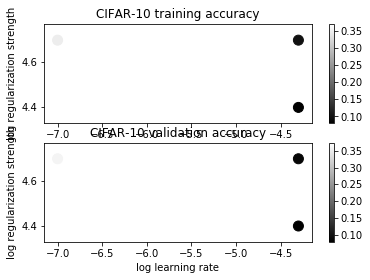

In [18]:
# Visualize the cross-validation results
import math
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [19]:
# Evaluate the best svm on test set
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

linear SVM on raw pixels final test set accuracy: 0.373000


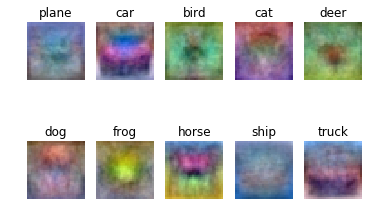

In [20]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best_svm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
      
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

### Inline question 2:
Describe what your visualized SVM weights look like, and offer a brief explanation for why they look they way that they do.

**Your answer:** *The visualized SVM weights look like they have the average temple(outline) of the corresponding objects, which are what they are expected to respond to. Because the scores is the inner pruduct between the sample and the corresponding weight, if we want to get to higher score in the correct label, the correspoding weight should be more parallel to the sample.*